# The analysis of the Home Credit Group dataset (II part)

### Importing libraries

The main libraries which will be used for the manipulation with data are pandas, suckb and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Researchpy, Math, Random will be used for conducting statistical tests, calculating confidence intervals. Sklearn and imblearn will be used for spliting data into training and testing samples, building and testing machine learning models. Optuna will be used for hyperparameter tuning. Tensorflow library will be used for deep learning. 

The functions which will be created in the process of analysis will be uploaded from a file "homecredit_utils.py".

In [17]:
import numpy as np 
import pandas as pd
import sqlite3
import duckdb
import random
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats
from scipy.stats import chi2_contingency, norm 
import researchpy as rp

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import optuna

import sklearn
import sklearn.ensemble
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, \
cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
recall_score, confusion_matrix as cfm, make_scorer, classification_report, mean_absolute_error,\
mean_squared_error,mean_squared_log_error,r2_score, roc_auc_score, average_precision_score, log_loss

from probatus.feature_elimination import EarlyStoppingShapRFECV
from sklearn.datasets import make_classification

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif , mutual_info_classif
from sklearn.feature_selection import RFE, RFECV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
import xgboost as xg

from imblearn.pipeline import make_pipeline, Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from category_encoders.woe import WOEEncoder

from yellowbrick.classifier import confusion_matrix as ycfm, ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

import joblib
import shap
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from homecredit_utils import *


#### Importing the initially preprocessed datasets

The files which were created as the result of exploratory analysis and initial preprocessing of the Home Credit Club data (see the file "homecredit_exploratory_analysis.ipynb" are imported and saved into pandas dataframes.

In [12]:
fulldata_train = pd.read_csv("data/fulldata_train.csv")

In [13]:
fulldata_test = pd.read_csv("data/fulldata_test.csv")

### Machine learning

#### Randomly selecting the data for machine learning

In order to train the model which would predict probabilities if clients of the Home Credit Club are risky (that is, have difficulties in paying loans in time), the data was randomly sampled from the fulldata_train dataset.

In [697]:
fulldata_sample = fulldata_train.sample(n=40000, random_state=42)


#### Spliting the data into training, validation, and test datasets

First, the data were split into feature variables and a target variable as well as into training, validation and test datasets. 

In [698]:
X = fulldata_sample.drop(['TARGET'],axis=1)
y = fulldata_sample['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=123)

#### Building a machine learning pipelines

Next, pipelines of transforming data were constructed. First, names of binary, categorical (with multiple values) and numerical normalized and other numerical features were identified and saved into separate lists.

For separation of binary features the functions 'binary_numeric" and 'get_binary_numeric" were applied. 

##### lists of features:

In [699]:
def binary_numeric(data):
    unique_values = data.unique()
    return len(unique_values) == 2


In [187]:
def get_binary_numeric(data):
    data_describe = data.describe()
    data_num =  data.loc[:,data_describe.columns]
    data_bin_num = data.loc[:, data.apply(binary_numeric)]
    if len(data_bin_num.columns) != 0:
        return data_bin_num
    else:
        pass


In [192]:
X_bin = get_binary_numeric(X)
elem = [f'"{item}"' for item in X_bin.columns]
print(', '.join(elem))

"NAME_CONTRACT_TYPE", "FLAG_OWN_REALTY", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "ORGANIZATION_TYPE_Advertising", "ORGANIZATION_TYPE_Agriculture", "ORGANIZATION_TYPE_Bank", "ORGANIZATION_TYPE_Business Entity Type 1", "ORGANIZATION_TYPE_Business Entity Type 2", "ORGANIZATION_TYPE_Business Entity Type 3", "ORGANIZATION_TYPE_Cleaning", "ORGANIZATION_TYPE_Construction", "ORGANIZATION_TYPE_Culture", "ORGANIZATION_TYPE_Electricity", "ORGANIZATION_TYPE_Emergency", "ORGANIZATION_TYPE_Government", "ORGANIZATION_TYPE_Hotel", "ORGANIZATION_TYPE_Housing", "ORGANIZATION_TYPE_Industry: type 1", "ORGANIZATION_TYPE_Industry: type 10", "ORGANIZATION_TYPE_Industry: type 11", "ORGANIZATION_TYPE_Industry: type 12", "ORGANIZATION_TYPE_Industry: type 13", "ORGANIZATION_TYPE_Industry: type 2", "OR

In [193]:
X_describe = X.describe()
X_num =  X[X_describe.columns]

col = ((X_num >1)|(X_num < 0)).any()
X_not_norm = X_num.loc[: , col]

X_norm = X_num.drop(X_not_norm, axis=1)
elem = [f'"{item}"' for item in X_norm.columns]
print(', '.join(elem))

"REGION_POPULATION_RELATIVE", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "TOTALAREA_MODE", "ORGANIZATION_TYPE_Advertising", "ORGANIZATION_TYPE_Agriculture", "ORGANIZATION_TYPE_Bank", "ORGANIZATION_TYPE_Business Entity Type 1", "ORGANIZATION_TYPE_Business Entity Type 2", "ORGANIZATION_TYPE_Business Entity Type 3", "ORGANIZATION_TYPE_Cleaning", "ORGANIZATION_TYPE_Construction", "ORGANIZATION_TYPE_Culture", "ORGANIZATION_TYPE_Electricity", "ORGANIZATION_TYPE_Emergency", "ORGANIZATION_TYPE_Government", "ORGANIZATION_TYPE_Hotel", "ORGANIZATION_TYPE_Housing", "ORGANIZATION_TYPE_Industry: type 1", "ORGANIZATION_TYPE_Industry: type 10", "ORGANIZATION_TYPE_Industry: type 11", "ORGANIZATION_TYPE_Industry: type 12", "ORGANIZATI

In [194]:
elem = [f'"{item}"' for item in X_not_norm.columns]
print(', '.join(elem))

"SK_ID_CURR", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "OBS_60_CNT_SOCIAL_CIRCLE", "DAYS_LAST_PHONE_CHANGE", "EDUCATION", "CAR_OWN", "LIVING_CONDITIONS_1", "LIVING_CONDITIONS_2", "CB_enquiries_1", "CB_enquiries_2", "WWAVG_AMT_ANNUITY", "WWAVG_AMT_APPLICATION", "WWAVG_AMT_CREDIT", "WWAVG_AMT_DOWN_PAYMENT", "WWAVG_AMT_GOODS_PRICE", "WAVG_CREDIT_END_LATE", "WAVG_CREDIT_DAY_OVERDUE", "WAVG_AMT_CREDIT_MAX_OVERDUE", "WAVG_CNT_CREDIT_PROLONG", "WAVG_AMT_CREDIT_SUM", "WAVG_AMT_CREDIT_SUM_DEBT", "WAVG_AMT_CREDIT_SUM_LIMIT", "WAVG_AMT_CREDIT_SUM_OVERDUE", "WAVG_DAYS_CREDIT_UPDATE", "WAVG_AVG_STATUS_0", "WAVG_AVG_STATUS_C", "WAVG_AVG_STATUS_X", "sums_of_days_late", "sums_of_days_in_time", "sums_of_amounts_late", "sums_of_amounts_in_time", "CNT_INSTALMENT_WAVG", "CNT_INSTALMENT_FUTURE_WAVG", "SK_DPD_WAVG", "SK_DP

In [191]:
X_describe = X.describe()
X_cat =  X.drop(X_describe.columns, axis=1)
elem = [f'"{item}"' for item in X_cat.columns]
print(', '.join(elem))

"NAME_CONTRACT_TYPE", "FLAG_OWN_REALTY", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"


In [197]:
numeric_features_1numeric_features_1 = list(X_not_norm.columns)
categorical_features_1 = list(X_cat.iloc[:,2:].columns)
binary_features_1 = list(X_bin.columns)


Normalised numerical features were identified with the help of the function which selects those feature names from the list X.columns which are not present in other lists.

In [522]:
def remove_duplicates(main_list, list1, list2, list3):
    combined_lists = list1 + list2 + list3
    result_list = [item for item in main_list if item not in combined_lists]
    return result_list



In [523]:
other_features_1 = remove_duplicates(list(X.columns), numeric_features_1, 
                                         categorical_features_1, binary_features_1)


Next, classes for different types of features and lists of instances of those classes were created.

In [205]:
class num_features_1:
    def __init__(self, name, content):
        self.name = name
        self.content = content

class cat_features_1:
    def __init__(self, name, content):
        self.name = name
        self.content = content

class bin_features_1:
    def __init__(self, name, content):
        self.name = name
        self.content = content

class o_features_1:
    def __init__(self, name, content):
        self.name = name
        self.content = content

In [206]:
numeric_features_list = [
    num_features_1("numeric_features_1", numeric_features_1)
]

categorical_features_list = [
    cat_features_1("categorical_features_1", categorical_features_1)
]

binary_features_list = [
    bin_features_1("binary_features_1", binary_features_1)
]

other_features_list = [
    o_features_1("other_features_1", other_features_1)
]

##### lists of transformers:

Separate lists for various types of transformers were created in order to simplify the process of pipeline and feature engeneering (examining the effects of different transformers on the metrics of various machine learning models)

In [207]:
encoders_list = [
                OneHotEncoder(sparse=False, handle_unknown='ignore'),
                WOEEncoder()
]

cat_imputers_list = [
 #   SimpleImputer(strategy='constant', fill_value="MISSING"),
    SimpleImputer(strategy='constant', fill_value=0)
]

num_imputers_list = [
  #  SimpleImputer(strategy='constant', fill_value=0),
    SimpleImputer(strategy="median")
]

scalers_list = [
    StandardScaler()
]

##### list of classifiers:

Various classifiers were included into a list of classifiers. SVC classifier was excluded from the list in the intermediary stage of modelling, as it was observed that to train the SVC classifier takes long time while the classifier does not perform well.

In [524]:
classifiers = [
    xg.XGBClassifier()
    ,RandomForestClassifier(class_weight = "balanced")
    ,ExtraTreesClassifier(class_weight = "balanced")
    ,GradientBoostingClassifier()
    ,LogisticRegression(class_weight = "balanced")
    #,SVC()
    ,KNeighborsClassifier()
    ,BaggingClassifier()
    ,AdaBoostClassifier()
]


##### Function for transformer pipelines:

Pipelines of various transformers for different types of features were combined into a single function "get_transformers".

In [525]:
def get_transformers (scaler, nimputer, cimputer, encoder):
    num_transformer = Pipeline([
          ('scaler', scaler),
          ('imputer', nimputer)])
    
    bin_transformer = Pipeline(steps=[
          ('ordinal', WOEEncoder()),
          ('imputer', nimputer)])

    cat_transformer = Pipeline(steps=[
          ('encoder', encoder),
          ('imputer', cimputer)])

    imp_transformer = Pipeline(steps=[
       ('imputer', nimputer)])
    
    return num_transformer, bin_transformer, cat_transformer, imp_transformer

#### Running the machine learning pipeline

The function for fitting classifiers, predicting the target variable in the validation dataset, cross-validation, getting metrics, printing metrics outputs and appending outputs into dictionnaries was created. 

In [144]:
def score_model(x_train, y_train, x_val, y_val, estimator, preprocessor, df, 
                models_list, classes, size, features, **kwargs):
    
    # Model fitting and prediction:
    pipeline = imbPipeline(steps = [
                   ('preprocessor', preprocessor),
                    ('selectKBest', SelectKBest(score_func=mutual_info_classif, k=features)),
                #   ('rfecv', RFECV(estimator=estimator, step=1, cv=5)),
                   ('randomundersampler', RandomUnderSampler(random_state=42)),
                   ('classifier',estimator)])
    
    model = pipeline.fit(x_train, y_train)
    prediction = model.predict(x_val)
    prediction_prob = model.predict_proba(x_val)
   
   # Cross-validation:
    scoring = {'accuracy': make_scorer(accuracy_score), "f1": make_scorer(f1_score)}
    cross_val = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    cross_vals.append([np.mean(x) for x in list(cross_val.values())])
    accuracy_scores = cross_val['test_accuracy']
    f1_scores = cross_val['test_f1']
    
    #Metrics:
    f1 = f1_score(y_val, prediction, average='macro').round(3)
    prec = precision_score(y_val, prediction, average='macro').round(3)
    rec = recall_score(y_val, prediction, average='macro').round(3)
    acc_sq = accuracy_score(y_val, prediction).round(3)
    report = classification_report(y_val, prediction, target_names=classes)
    loss = log_loss(y_val, prediction_prob).round(3)
    roc_auc = roc_auc_score(y_val, prediction).round(3)
    pr_auc = average_precision_score(y_val, prediction).round(3)
    
   #Prints:
    print (estimator.__class__.__name__)
    conf = confusion_matrix(model, x_train, y_train, x_val, y_val, classes=classes,
        cmap="YlGn", size=size, **kwargs)
    print("Classification Report:")
    print(report)
    print (f'Cross-validation')
    print ("Accuracy scores: {}".format(accuracy_scores))
    avg_list = sum(list(accuracy_scores))/len(list(accuracy_scores))
    print (f"Accuracy score (average): {avg_list}")
    print ("F1 scores for 'Yes' values: {}".format(f1_scores))
    print (f"Average F1 score: {f1}")
    print (f"ROC-AUC score: {roc_auc}")
    print (f"PR-AUC score: {pr_auc}")
    print (f"Log-loss: {loss}")
    print('')
    
    #Appends:
    models_list.append(model)
    predictions[f'{estimator.__class__.__name__}'].append(prediction)
    predictions_prob[f'{estimator.__class__.__name__}'].append(prediction_prob)
    df["model_name"].append(f'{estimator.__class__.__name__}')
    df["a_score"].append(acc_sq)
    df["f1_score"].append(f1)
    df["precision_score"].append(prec)
    df["recall_score"].append(rec)
    df["ROC_AUC_score"].append(roc_auc)
    df["PR_AUC_score"].append(pr_auc)
    df["loss"].append(loss)
    return model
    

A function for building empty dictionnaries to save modelling outputs with keys for each type of data was created.

In [526]:
def get_empty_lists_and_dfs():
    cross_vals = []
    preprocessors = []
    models = []
    predictions = {}
    predictions_prob = {}
    metrics_df = {}
    metrics_df["precision_score"] = []
    metrics_df["recall_score"] = []
    metrics_df["model_name"] = []
    metrics_df["a_score"] = []
    metrics_df["f1_score"] = []
    metrics_df["ROC_AUC_score"] = []
    metrics_df["PR_AUC_score"] = []
    metrics_df["loss"] = []
    metrics_df["exec_time"] = []
    metrics_df["encoders"] = []
    metrics_df["cimputers"] = []
    metrics_df["nimputers"] = []
    metrics_df["scalers"] = []
    metrics_df["num_features"] = []
    metrics_df["cat_features"] = []
    metrics_df["bin_features"] = []
    metrics_df["other_features"] = []
    optuna_df = {}
    optuna_df["best_ROC_AUC_score"] = []
    optuna_df["best_params"] = []
    optuna_df["exec_time"] = []
    return cross_vals, models, predictions, predictions_prob, metrics_df, preprocessors, optuna_df

In [146]:
classes_target=['No', 'Yes']
size_target = (200, 100)

The function to loop over lists of features, pipelines of transformers and classifiers and to save data into dictionaries (to be transformed into pandas dataframes) and models into local files was created. 

In [149]:
def run_models(metrics_df, x_train, y_train, x_val, y_val, features,
               numeric_features_list,
               binary_features_list,
               categorical_features_list,
               other_features_list,
              scalers_list,
              num_imputers_list,
               cat_imputers_list,
              encoders_list, 
              classifiers):
                                                                                                                   
    # Running pipelines on various combinations of transformers and features:

    for numeric_features, binary_features, categorical_features, other_features in zip(numeric_features_list,
                                                                                       binary_features_list,
                                                                                       categorical_features_list,
                                                                                       other_features_list):
        for scaler in scalers_list:
            for nimputer, cimputer in zip(num_imputers_list, cat_imputers_list):
                for encoder in encoders_list:

                    num_transformer, bin_transformer, cat_transformer, imp_transformer = get_transformers(scaler, 
                                                                                                          nimputer,
                                                                                                          cimputer,
                                                                                                          encoder)
                    preprocessor = ColumnTransformer(
                           transformers=[
                            ('numeric', num_transformer, numeric_features.content),
                            ('binary', bin_transformer, binary_features.content),
                            ('categorical', cat_transformer, categorical_features.content),
                            ('other', imp_transformer, other_features.content)
                        ])
                    preprocessors.append(preprocessor)

                    print(f'Parameters for the dataset and transformers: {encoder.__class__.__name__}, \
{nimputer}, {cimputer}, {scaler.__class__.__name__}, {numeric_features.name}, \
{binary_features.name}, {categorical_features.name}, {other_features.name}')

                    for classifier in classifiers:

                        predictions[f'{classifier.__class__.__name__}'] = []
                        predictions_prob[f'{classifier.__class__.__name__}'] = []
                        start_time1 = time.time()
                        model = score_model(X_train, y_train, X_val, y_val, classifier, preprocessor, metrics_df, 
                                    models, classes_target, size_target, features)
                        end_time1 = time.time()
                        exec_time1 = end_time1 - start_time1
                        metrics_df["exec_time"].append(exec_time1)
                        metrics_df["encoders"].append(encoder.__class__.__name__)
                        metrics_df["nimputers"].append(nimputer.__class__.__name__)
                        metrics_df["cimputers"].append(cimputer.__class__.__name__)
                        metrics_df["scalers"].append(scaler.__class__.__name__)
                        metrics_df["num_features"].append(numeric_features.name)
                        metrics_df["cat_features"].append(categorical_features.name)
                        metrics_df["bin_features"].append(binary_features.name)
                        metrics_df["other_features"].append(other_features.name)
                        print('')
                        print(f'Execution time: {exec_time1}')
                        joblib.dump(model, f'model_{classifier.__class__.__name__}_\
{encoder.__class__.__name__}_{nimputer}_{cimputer}_\
{numeric_features.name}.joblib')
                        print('')
    metrics_df = pd.DataFrame(metrics_df)
    metrics_df.to_csv(f'homecredit_features_{features}.csv')
    

The function (presented above) was run on the mentioned lists. Outputs present metrics for different classifiers, combinations of features and transformers which were used for training the models are also mentioned in the output.

Initially, models were trained on the total number of available features (315).

Parameters for the dataset and transformers: OneHotEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_1, binary_features_1, categorical_features_1, other_features_1
XGBClassifier


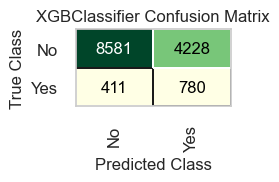

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.67      0.79     12809
         Yes       0.16      0.65      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.56      0.66      0.52     14000
weighted avg       0.89      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.66035714 0.67892857 0.66035714 0.65571429 0.67071429]
Accuracy score (average): 0.6652142857142858
F1 scores for 'Yes' values: [0.24102155 0.24135021 0.22367347 0.22006472 0.23294509]
Average F1 score: 0.519
ROC-AUC score: 0.662
PR-AUC score: 0.131
Log-loss: 0.726


Execution time: 59.361830949783325

RandomForestClassifier


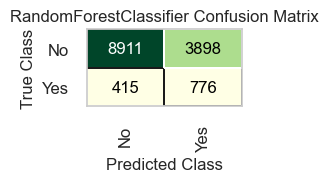

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.70      0.81     12809
         Yes       0.17      0.65      0.26      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.65892857 0.68178571 0.68       0.68       0.68642857]
Accuracy score (average): 0.6774285714285715
F1 scores for 'Yes' values: [0.23782921 0.2338779  0.24705882 0.23287671 0.2417962 ]
Average F1 score: 0.535
ROC-AUC score: 0.674
PR-AUC score: 0.138
Log-loss: 0.614


Execution time: 58.41139578819275

ExtraTreesClassifier


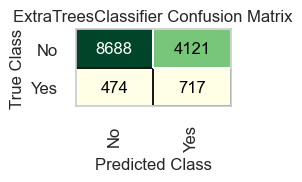

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.68      0.79     12809
         Yes       0.15      0.60      0.24      1191

    accuracy                           0.67     14000
   macro avg       0.55      0.64      0.51     14000
weighted avg       0.88      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65857143 0.65892857 0.65392857 0.67607143 0.65428571]
Accuracy score (average): 0.6603571428571429
F1 scores for 'Yes' values: [0.22778675 0.21913328 0.22417934 0.22544833 0.22061192]
Average F1 score: 0.514
ROC-AUC score: 0.64
PR-AUC score: 0.123
Log-loss: 0.625


Execution time: 58.527832984924316

GradientBoostingClassifier


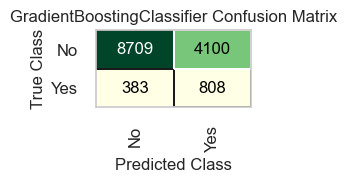

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     12809
         Yes       0.16      0.68      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.66571429 0.68357143 0.70178571 0.69035714 0.68035714]
Accuracy score (average): 0.6843571428571428
F1 scores for 'Yes' values: [0.2512     0.24273504 0.25246195 0.24543081 0.24726661]
Average F1 score: 0.53
ROC-AUC score: 0.679
PR-AUC score: 0.139
Log-loss: 0.599


Execution time: 64.75929999351501

LogisticRegression


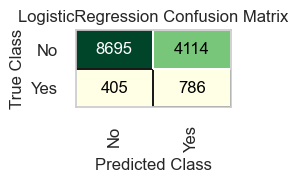

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.79     12809
         Yes       0.16      0.66      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.66321429 0.67964286 0.67964286 0.69821429 0.66857143]
Accuracy score (average): 0.6778571428571428
F1 scores for 'Yes' values: [0.24257028 0.2531224  0.24558452 0.24079066 0.23558484]
Average F1 score: 0.526
ROC-AUC score: 0.669
PR-AUC score: 0.135
Log-loss: 0.625


Execution time: 58.36784625053406

KNeighborsClassifier


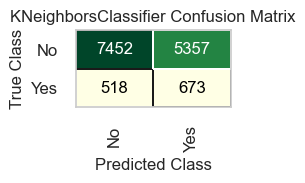

Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.58      0.72     12809
         Yes       0.11      0.57      0.19      1191

    accuracy                           0.58     14000
   macro avg       0.52      0.57      0.45     14000
weighted avg       0.86      0.58      0.67     14000

Cross-validation
Accuracy scores: [0.53       0.54607143 0.54535714 0.56107143 0.56928571]
Accuracy score (average): 0.5503571428571429
F1 scores for 'Yes' values: [0.1754386  0.1654629  0.16194865 0.15879535 0.15899582]
Average F1 score: 0.452
ROC-AUC score: 0.573
PR-AUC score: 0.1
Log-loss: 1.736


Execution time: 57.74232506752014

BaggingClassifier


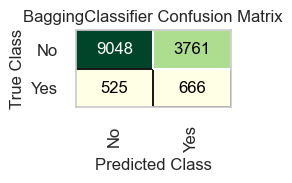

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.71      0.81     12809
         Yes       0.15      0.56      0.24      1191

    accuracy                           0.69     14000
   macro avg       0.55      0.63      0.52     14000
weighted avg       0.88      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.67714286 0.68857143 0.6825     0.695      0.71142857]
Accuracy score (average): 0.6909285714285713
F1 scores for 'Yes' values: [0.22068966 0.20727273 0.22493461 0.22363636 0.23484848]
Average F1 score: 0.523
ROC-AUC score: 0.633
PR-AUC score: 0.122
Log-loss: 0.942


Execution time: 59.1973180770874

AdaBoostClassifier


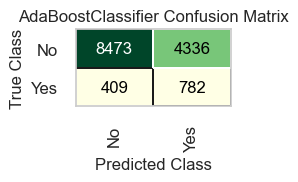

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.66      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.51     14000
weighted avg       0.89      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.63642857 0.685      0.65714286 0.6825     0.6725    ]
Accuracy score (average): 0.6667142857142857
F1 scores for 'Yes' values: [0.22878788 0.23965517 0.23688394 0.22762815 0.24402308]
Average F1 score: 0.515
ROC-AUC score: 0.659
PR-AUC score: 0.13
Log-loss: 0.689


Execution time: 58.820992946624756

Parameters for the dataset and transformers: WOEEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_1, binary_features_1, categorical_features_1, other_features_1
XGBClassifier


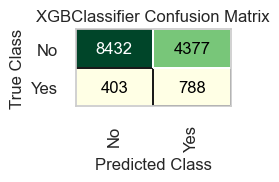

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.66      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.51     14000
weighted avg       0.89      0.66      0.73     14000

Cross-validation
Accuracy scores: [0.6575     0.6725     0.67535714 0.66142857 0.66107143]
Accuracy score (average): 0.6655714285714286
F1 scores for 'Yes' values: [0.24189723 0.23005877 0.24186822 0.22801303 0.22908205]
Average F1 score: 0.514
ROC-AUC score: 0.66
PR-AUC score: 0.13
Log-loss: 0.743


Execution time: 52.551705837249756

RandomForestClassifier


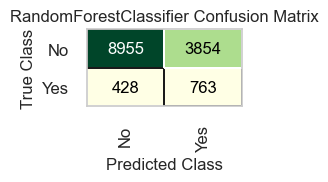

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.70      0.81     12809
         Yes       0.17      0.64      0.26      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.66285714 0.67428571 0.68535714 0.68642857 0.66678571]
Accuracy score (average): 0.675142857142857
F1 scores for 'Yes' values: [0.24358974 0.2284264  0.24377682 0.228471   0.23461854]
Average F1 score: 0.535
ROC-AUC score: 0.67
PR-AUC score: 0.136
Log-loss: 0.612


Execution time: 51.995522260665894

ExtraTreesClassifier


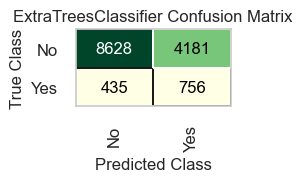

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.67      0.79     12809
         Yes       0.15      0.63      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.55      0.65      0.52     14000
weighted avg       0.88      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65821429 0.655      0.65178571 0.67       0.67035714]
Accuracy score (average): 0.6610714285714285
F1 scores for 'Yes' values: [0.23378703 0.22096774 0.23046567 0.21694915 0.23275145]
Average F1 score: 0.518
ROC-AUC score: 0.654
PR-AUC score: 0.128
Log-loss: 0.627


Execution time: 51.88545489311218

GradientBoostingClassifier


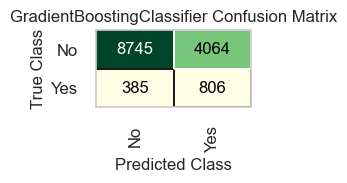

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     12809
         Yes       0.17      0.68      0.27      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.65785714 0.69928571 0.69928571 0.69035714 0.69035714]
Accuracy score (average): 0.6874285714285714
F1 scores for 'Yes' values: [0.2515625  0.26398601 0.25486726 0.24279476 0.25451419]
Average F1 score: 0.532
ROC-AUC score: 0.68
PR-AUC score: 0.14
Log-loss: 0.601


Execution time: 58.42783999443054

LogisticRegression


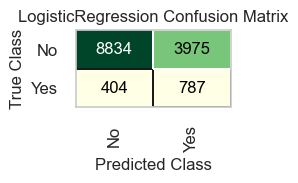

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.69      0.80     12809
         Yes       0.17      0.66      0.26      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.66928571 0.69357143 0.69       0.69607143 0.66964286]
Accuracy score (average): 0.6837142857142857
F1 scores for 'Yes' values: [0.25322581 0.25520833 0.25557461 0.24623561 0.23363712]
Average F1 score: 0.533
ROC-AUC score: 0.675
PR-AUC score: 0.138
Log-loss: 0.61


Execution time: 51.07777118682861

KNeighborsClassifier


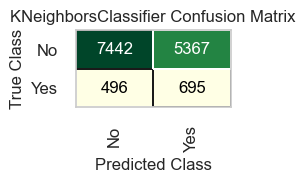

Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.58      0.72     12809
         Yes       0.11      0.58      0.19      1191

    accuracy                           0.58     14000
   macro avg       0.53      0.58      0.45     14000
weighted avg       0.87      0.58      0.67     14000

Cross-validation
Accuracy scores: [0.56785714 0.52714286 0.55321429 0.54571429 0.57714286]
Accuracy score (average): 0.5542142857142858
F1 scores for 'Yes' values: [0.17462483 0.15776081 0.17643186 0.16205534 0.15669516]
Average F1 score: 0.455
ROC-AUC score: 0.582
PR-AUC score: 0.102
Log-loss: 1.726


Execution time: 50.99345803260803

BaggingClassifier


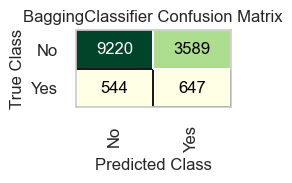

Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.72      0.82     12809
         Yes       0.15      0.54      0.24      1191

    accuracy                           0.70     14000
   macro avg       0.55      0.63      0.53     14000
weighted avg       0.88      0.70      0.77     14000

Cross-validation
Accuracy scores: [0.68107143 0.70428571 0.71678571 0.71642857 0.69892857]
Accuracy score (average): 0.7035
F1 scores for 'Yes' values: [0.22144725 0.2247191  0.23233301 0.23359073 0.21288515]
Average F1 score: 0.528
ROC-AUC score: 0.632
PR-AUC score: 0.122
Log-loss: 0.936


Execution time: 52.09188723564148

AdaBoostClassifier


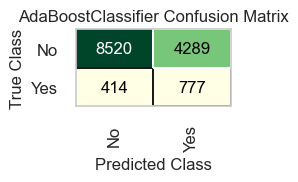

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.67      0.78     12809
         Yes       0.15      0.65      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.52     14000
weighted avg       0.89      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.63392857 0.67821429 0.65928571 0.68285714 0.66392857]
Accuracy score (average): 0.6636428571428572
F1 scores for 'Yes' values: [0.21934501 0.23837701 0.22439024 0.23448276 0.23183673]
Average F1 score: 0.516
ROC-AUC score: 0.659
PR-AUC score: 0.13
Log-loss: 0.688


Execution time: 52.365379095077515



In [152]:
cross_vals, models, predictions, predictions_prob, scores1, preprocessors, optuna_df = get_empty_lists_and_dfs() 
run_models(scores1, X_train, y_train, X_val, y_val, 315,
          numeric_features_list,
           binary_features_list,
           categorical_features_list,
           other_features_list,
           scalers_list,
           num_imputers_list,
           cat_imputers_list,
            encoders_list,
           classifiers)

Next, models are trained on a limited number of features (150). Features are selected by step  ('selectKBest', SelectKBest(score_func=mutual_info_classif, k=features)) in the pipeline. 

Parameters for the dataset and transformers: OneHotEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_1, binary_features_1, categorical_features_1, other_features_1
XGBClassifier


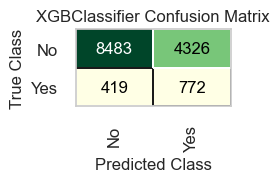

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.65      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.51     14000
weighted avg       0.88      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.64571429 0.65642857 0.65964286 0.66714286 0.66571429]
Accuracy score (average): 0.6589285714285713
F1 scores for 'Yes' values: [0.23338485 0.22916667 0.23453815 0.21150592 0.24271845]
Average F1 score: 0.513
ROC-AUC score: 0.655
PR-AUC score: 0.128
Log-loss: 0.734


Execution time: 57.58500599861145

RandomForestClassifier


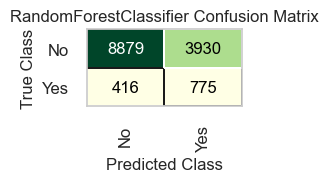

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.69      0.80     12809
         Yes       0.16      0.65      0.26      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.66321429 0.68714286 0.68892857 0.69142857 0.67821429]
Accuracy score (average): 0.6817857142857142
F1 scores for 'Yes' values: [0.25099285 0.24090121 0.24457936 0.23674912 0.24476111]
Average F1 score: 0.533
ROC-AUC score: 0.672
PR-AUC score: 0.137
Log-loss: 0.609


Execution time: 58.03208017349243

ExtraTreesClassifier


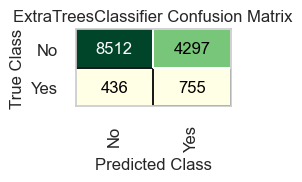

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.63      0.24      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.65      0.51     14000
weighted avg       0.88      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.65571429 0.64821429 0.66357143 0.68357143 0.66178571]
Accuracy score (average): 0.6625714285714286
F1 scores for 'Yes' values: [0.23492063 0.21638823 0.23909532 0.23090278 0.21929101]
Average F1 score: 0.512
ROC-AUC score: 0.649
PR-AUC score: 0.126
Log-loss: 0.63


Execution time: 57.81312084197998

GradientBoostingClassifier


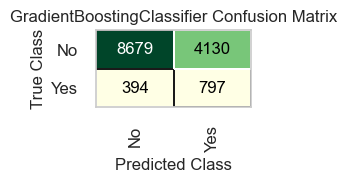

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.79     12809
         Yes       0.16      0.67      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.65714286 0.6975     0.69785714 0.67964286 0.66678571]
Accuracy score (average): 0.6797857142857143
F1 scores for 'Yes' values: [0.24528302 0.25242718 0.24733096 0.23659574 0.23461854]
Average F1 score: 0.527
ROC-AUC score: 0.673
PR-AUC score: 0.136
Log-loss: 0.604


Execution time: 515.3310532569885

LogisticRegression


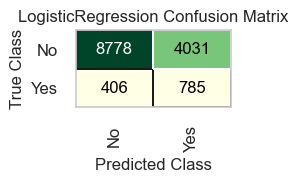

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.69      0.80     12809
         Yes       0.16      0.66      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.67321429 0.68785714 0.67607143 0.70214286 0.68928571]
Accuracy score (average): 0.6857142857142856
F1 scores for 'Yes' values: [0.25910931 0.25171233 0.23845508 0.24456522 0.23684211]
Average F1 score: 0.53
ROC-AUC score: 0.672
PR-AUC score: 0.136
Log-loss: 0.604


Execution time: 57.79024791717529

KNeighborsClassifier


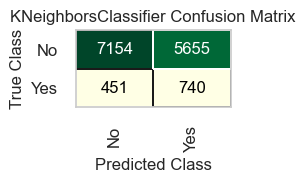

Classification Report:
              precision    recall  f1-score   support

          No       0.94      0.56      0.70     12809
         Yes       0.12      0.62      0.20      1191

    accuracy                           0.56     14000
   macro avg       0.53      0.59      0.45     14000
weighted avg       0.87      0.56      0.66     14000

Cross-validation
Accuracy scores: [0.555      0.56142857 0.54142857 0.53285714 0.55035714]
Accuracy score (average): 0.5482142857142858
F1 scores for 'Yes' values: [0.15810811 0.16348774 0.16297262 0.1462141  0.16567263]
Average F1 score: 0.448
ROC-AUC score: 0.59
PR-AUC score: 0.104
Log-loss: 2.035


Execution time: 57.606423139572144

BaggingClassifier


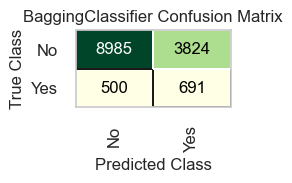

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.70      0.81     12809
         Yes       0.15      0.58      0.24      1191

    accuracy                           0.69     14000
   macro avg       0.55      0.64      0.52     14000
weighted avg       0.88      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.66607143 0.695      0.69607143 0.69714286 0.7075    ]
Accuracy score (average): 0.6923571428571428
F1 scores for 'Yes' values: [0.23297785 0.22080292 0.21711132 0.22344322 0.23813953]
Average F1 score: 0.524
ROC-AUC score: 0.641
PR-AUC score: 0.125
Log-loss: 1.013


Execution time: 58.07448720932007

AdaBoostClassifier


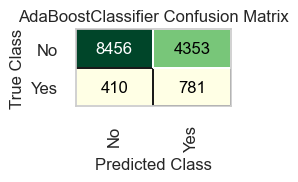

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.66      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.51     14000
weighted avg       0.89      0.66      0.73     14000

Cross-validation
Accuracy scores: [0.65714286 0.67607143 0.66214286 0.66857143 0.66857143]
Accuracy score (average): 0.6665
F1 scores for 'Yes' values: [0.24409449 0.23845508 0.22838499 0.23178808 0.23305785]
Average F1 score: 0.514
ROC-AUC score: 0.658
PR-AUC score: 0.129
Log-loss: 0.689


Execution time: 64.80393409729004

Parameters for the dataset and transformers: WOEEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_1, binary_features_1, categorical_features_1, other_features_1
XGBClassifier


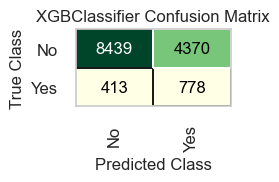

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.65      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.51     14000
weighted avg       0.89      0.66      0.73     14000

Cross-validation
Accuracy scores: [0.65821429 0.66714286 0.66392857 0.66107143 0.65571429]
Accuracy score (average): 0.6612142857142856
F1 scores for 'Yes' values: [0.24107851 0.22975207 0.23308883 0.22149303 0.23248408]
Average F1 score: 0.512
ROC-AUC score: 0.656
PR-AUC score: 0.128
Log-loss: 0.747


Execution time: 53.73718500137329

RandomForestClassifier


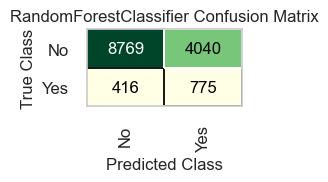

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.68      0.80     12809
         Yes       0.16      0.65      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.67071429 0.69178571 0.675      0.68785714 0.68214286]
Accuracy score (average): 0.6815
F1 scores for 'Yes' values: [0.24673203 0.24496938 0.23141892 0.24       0.24190801]
Average F1 score: 0.528
ROC-AUC score: 0.668
PR-AUC score: 0.134
Log-loss: 0.615


Execution time: 52.83474087715149

ExtraTreesClassifier


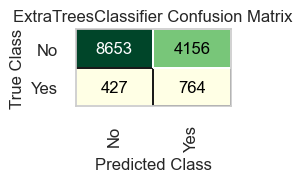

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.68      0.79     12809
         Yes       0.16      0.64      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.55      0.66      0.52     14000
weighted avg       0.89      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65607143 0.67       0.66857143 0.67642857 0.65357143]
Accuracy score (average): 0.6649285714285714
F1 scores for 'Yes' values: [0.23993686 0.23762376 0.23432343 0.22959184 0.23015873]
Average F1 score: 0.52
ROC-AUC score: 0.659
PR-AUC score: 0.13
Log-loss: 0.621


Execution time: 52.443227767944336

GradientBoostingClassifier


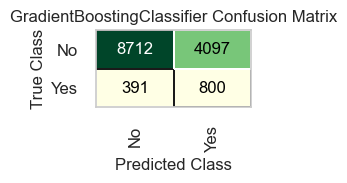

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     12809
         Yes       0.16      0.67      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.66607143 0.69107143 0.695      0.69214286 0.69464286]
Accuracy score (average): 0.6877857142857142
F1 scores for 'Yes' values: [0.25852498 0.24454148 0.24424779 0.23172906 0.24802111]
Average F1 score: 0.529
ROC-AUC score: 0.676
PR-AUC score: 0.138
Log-loss: 0.605


Execution time: 56.264875173568726

LogisticRegression


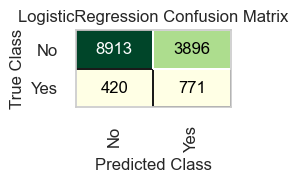

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.70      0.81     12809
         Yes       0.17      0.65      0.26      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.67857143 0.68714286 0.69178571 0.70142857 0.67535714]
Accuracy score (average): 0.6868571428571429
F1 scores for 'Yes' values: [0.26829268 0.25383305 0.25667528 0.24955117 0.23031329]
Average F1 score: 0.534
ROC-AUC score: 0.672
PR-AUC score: 0.137
Log-loss: 0.608


Execution time: 51.36406493186951

KNeighborsClassifier


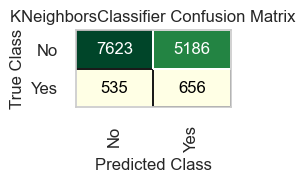

Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.60      0.73     12809
         Yes       0.11      0.55      0.19      1191

    accuracy                           0.59     14000
   macro avg       0.52      0.57      0.46     14000
weighted avg       0.86      0.59      0.68     14000

Cross-validation
Accuracy scores: [0.54964286 0.58035714 0.5575     0.585      0.59857143]
Accuracy score (average): 0.5742142857142858
F1 scores for 'Yes' values: [0.17202889 0.17078335 0.16       0.16161616 0.17956204]
Average F1 score: 0.457
ROC-AUC score: 0.573
PR-AUC score: 0.1
Log-loss: 1.639


Execution time: 51.14260387420654

BaggingClassifier


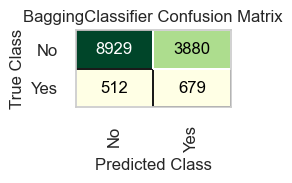

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.70      0.80     12809
         Yes       0.15      0.57      0.24      1191

    accuracy                           0.69     14000
   macro avg       0.55      0.63      0.52     14000
weighted avg       0.88      0.69      0.75     14000

Cross-validation
Accuracy scores: [0.67321429 0.695      0.69321429 0.68392857 0.69964286]
Accuracy score (average): 0.689
F1 scores for 'Yes' values: [0.23430962 0.21072089 0.20389249 0.20911528 0.21767442]
Average F1 score: 0.519
ROC-AUC score: 0.634
PR-AUC score: 0.121
Log-loss: 1.024


Execution time: 51.60221004486084

AdaBoostClassifier


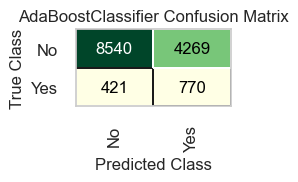

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.67      0.78     12809
         Yes       0.15      0.65      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.55      0.66      0.52     14000
weighted avg       0.88      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65607143 0.68107143 0.67142857 0.66071429 0.67214286]
Accuracy score (average): 0.6682857142857143
F1 scores for 'Yes' values: [0.24113475 0.23740393 0.23333333 0.22258592 0.23880597]
Average F1 score: 0.516
ROC-AUC score: 0.657
PR-AUC score: 0.129
Log-loss: 0.689


Execution time: 52.7132363319397



In [154]:
cross_vals, models, predictions, predictions_prob, scores2, preprocessors, optuna_df = get_empty_lists_and_dfs() 
run_models(scores2, X_train, y_train, X_val, y_val, 150,
           numeric_features_list,
           binary_features_list,
           categorical_features_list,
           other_features_list,
              scalers_list,
              num_imputers_list,
            cat_imputers_list,
              encoders_list,
             classifiers)

Metrics of different models can be observed in the dataframes 'scores1' (appended with the output data from the first run) and 'scores2' (from the second run) and in the bar plots. 

In [155]:
scores1 = pd.DataFrame(scores1)
#scores1 = scores1.set_index("model_name")
scores1 = scores1.reset_index(drop=False)
scores1['model'] = scores1['model_name'].str.cat(scores1['index'].astype(str), sep=' ')

scores1 = scores1.set_index('model')
scores1 = pd.DataFrame(scores1).sort_values("ROC_AUC_score", ascending = False)

In [156]:
scores1

,index,precision_score,recall_score,model_name,a_score,f1_score,ROC_AUC_score,PR_AUC_score,loss,exec_time,encoders,cimputers,nimputers,scalers,num_features,cat_features,bin_features,other_features
model,,,,,,,,,,,,,,,,,,
GradientBoostingClassifier 11,11,0.562,0.680,GradientBoostingClassifier,0.682,0.532,0.680,0.140,0.601,58.427840,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
GradientBoostingClassifier 3,3,0.561,0.679,GradientBoostingClassifier,0.680,0.530,0.679,0.139,0.599,64.759300,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
LogisticRegression 12,12,0.561,0.675,LogisticRegression,0.687,0.533,0.675,0.138,0.610,51.077771,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
RandomForestClassifier 1,1,0.561,0.674,RandomForestClassifier,0.692,0.535,0.674,0.138,0.614,58.411396,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
RandomForestClassifier 9,9,0.560,0.670,RandomForestClassifier,0.694,0.535,0.670,0.136,0.612,51.995522,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
LogisticRegression 4,4,0.558,0.669,LogisticRegression,0.677,0.526,0.669,0.135,0.625,58.367846,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
XGBClassifier 0,0,0.555,0.662,XGBClassifier,0.669,0.519,0.662,0.131,0.726,59.361831,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
XGBClassifier 8,8,0.553,0.660,XGBClassifier,0.659,0.514,0.660,0.130,0.743,52.551706,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
AdaBoostClassifier 7,7,0.553,0.659,AdaBoostClassifier,0.661,0.515,0.659,0.130,0.689,58.820993,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1


In [157]:
scores2 = pd.DataFrame(scores2)
#scores2 = scores2.set_index("model_name")
scores2 = scores2.reset_index(drop=False)
scores2['model'] = scores2['model_name'].str.cat(scores2['index'].astype(str), sep=' ')

scores2 = scores2.set_index('model')
scores2 = pd.DataFrame(scores2).sort_values("ROC_AUC_score", ascending = False)

In [158]:

scores2

,index,precision_score,recall_score,model_name,a_score,f1_score,ROC_AUC_score,PR_AUC_score,loss,exec_time,encoders,cimputers,nimputers,scalers,num_features,cat_features,bin_features,other_features
model,,,,,,,,,,,,,,,,,,
GradientBoostingClassifier 11,11,0.560,0.676,GradientBoostingClassifier,0.679,0.529,0.676,0.138,0.605,56.264875,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
GradientBoostingClassifier 3,3,0.559,0.673,GradientBoostingClassifier,0.677,0.527,0.673,0.136,0.604,515.331053,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
RandomForestClassifier 1,1,0.560,0.672,RandomForestClassifier,0.690,0.533,0.672,0.137,0.609,58.032080,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
LogisticRegression 4,4,0.559,0.672,LogisticRegression,0.683,0.530,0.672,0.136,0.604,57.790248,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
LogisticRegression 12,12,0.560,0.672,LogisticRegression,0.692,0.534,0.672,0.137,0.608,51.364065,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
RandomForestClassifier 9,9,0.558,0.668,RandomForestClassifier,0.682,0.528,0.668,0.134,0.615,52.834741,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
ExtraTreesClassifier 10,10,0.554,0.659,ExtraTreesClassifier,0.673,0.520,0.659,0.130,0.621,52.443228,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
AdaBoostClassifier 7,7,0.553,0.658,AdaBoostClassifier,0.660,0.514,0.658,0.129,0.689,64.803934,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
AdaBoostClassifier 15,15,0.553,0.657,AdaBoostClassifier,0.665,0.516,0.657,0.129,0.689,52.713236,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1


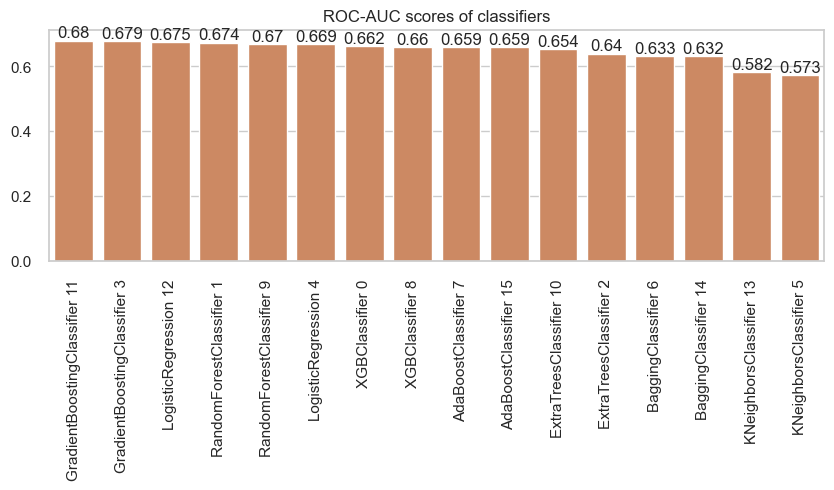

In [530]:
plot_bars(scores1, "ROC_AUC_score", "", "ROC-AUC scores of classifiers", (10,3))

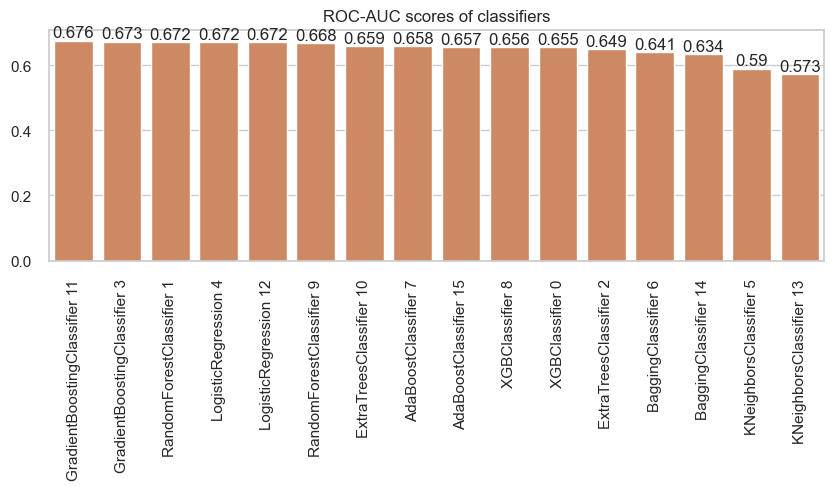

In [529]:
plot_bars(scores2, "ROC_AUC_score", "", "ROC-AUC scores of classifiers", (10,3))

It can be seen the best performance (the highest roc-auc score 0.68 which is higher that random guessing (score 0.5)) was achieved by the Gradient Boosting classifier with the WOE encoder and 315 features. Also, quite high scores for this classifier were achieved also with the combination of 150 features and one-hot encoder for categorical variables.

It can be observed that all classifiers, with exception of KNeighbors classifier which performed worse, were able to achieve quite similar performance (roc-auc score between 0.6 and 0.7).

The models predict the value 0 (clients who do not have payment difficulties) (max 1 score for "No" - 0.8) much better than the value 1 (persons with payment difficulties) (max f1 score for "Yes" - 0.26).


#### Bayesian optimization with the Optuna library

Hyperparameter tuning of model parameter was conducted by using the Bayesian optimization (Optuna). Two functions were created - 'set_objective' function which sets parameters for hyperparameter tuning and 'run_optuna' function which runs Optuna's function 'objective' with Optuna's study in loops of lists of feature combinations and transformer pipelines. These functions are helpful when there is a need to run Bayesian optimization many times by trying different transformers or combinations of features.

In [223]:
def set_objective(trial, X_train, y_train, X_val, y_val):
    classifier_name = trial.suggest_categorical('classifier', ['XGB', 'RF', 'ET', 'GB', 'LR', 'KNN', 
                                                               'Bagging', 'AdaBoost'])

    if classifier_name == 'XGB':
        classifier = xg.XGBClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,1000, step = 100),
        max_depth = trial.suggest_int('max_depth', 3, 9, step = 3),
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log = True),
        subsample = trial.suggest_float('subsample', 0.6, 1, step = 0.2)
        )
        classifier.fit(X_train, y_train)

    elif classifier_name == 'RF':
        classifier = RandomForestClassifier(
       # max_features = trial.suggest_int("max_features", 6,32, step = 5),
        n_estimators = trial.suggest_int("n_estimators", 10,101, step = 10),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
        max_samples = trial.suggest_float("max_samples",0.2, 1),
        random_state = 42
        )
        classifier.fit(X_train, y_train)
        
    elif classifier_name == 'ET':
        classifier = ExtraTreesClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
    #    max_features = trial.suggest_int("max_features", 6,32, step = 5),
        max_depth = trial.suggest_int('max_depth',1, 9, step = 4),
        )
        classifier.fit(X_train, y_train)
        
    elif classifier_name == 'GB':
        classifier = GradientBoostingClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100,500, step = 200),
        max_depth = trial.suggest_int("rf_max_depth", 2, 64, log=True),
     #   max_features = trial.suggest_int("max_features", 6,32, step = 5),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log = True)
        )
        classifier.fit(X_train, y_train)
        
    elif classifier_name == 'LR':
        classifier = LogisticRegression(
            C=trial.suggest_float('C', 1, 9, step = 4),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver=trial.suggest_categorical('solver', ['liblinear', 'saga'])
        )
        classifier.fit(X_train, y_train)
        
    elif classifier_name == 'KNN':
        classifier = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 7, step = 2),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            leaf_size=trial.suggest_int('leaf_size', 30, 90, step = 30)
        )
        classifier.fit(X_train, y_train)
        
    elif classifier_name == 'Bagging':
        classifier = BaggingClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 90, step = 20),
       #     max_features = trial.suggest_int("max_features", 6,32, step = 5),
            max_samples=trial.suggest_float('max_samples', 0.5, 0.9, step = 0.2),
        )
        classifier.fit(X_train, y_train)
        
    else:
        classifier = AdaBoostClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 200, step = 50),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 10.0, log = True)
        )
        classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_val)
    score = roc_auc_score(y_val, y_pred)

    return score


In [225]:
def run_optuna():
    cross_vals, models, predictions, predictions_prob, scores, preprocessors, optuna_df = get_empty_lists_and_dfs()

    # Running pipelines on various combinations of transformers and features:

    for numeric_features, binary_features, categorical_features, other_features in zip(numeric_features_list,
                                                                                       binary_features_list,
                                                                                       categorical_features_list,
                                                                                       other_features_list):
        for scaler in scalers_list:
            for nimputer, cimputer in zip(num_imputers_list, cat_imputers_list):
                for encoder in encoders_list:

                    num_transformer, bin_transformer, cat_transformer, imp_transformer = get_transformers(scaler, 
                                                                                                          nimputer,
                                                                                                          cimputer,
                                                                                                          encoder)
                    preprocessor = ColumnTransformer(
                           transformers=[
                            ('numeric', num_transformer, numeric_features.content),
                            ('binary', bin_transformer, binary_features.content),
                            ('categorical', cat_transformer, categorical_features.content),
                            ('other', imp_transformer, other_features.content)
                        ])
                    preprocessors.append(preprocessor)

                    # Hyperparameter tuning - Bayesian optimization:

                    if isinstance(encoder, WOEEncoder):
                        X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
                        X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val, y_val))

                        randomundersampler = RandomUnderSampler(random_state=42)
                        X_resampled_train, y_resampled_train = randomundersampler.fit_resample(X_pipe_train, y_train)

                        def objective(trial):
                            return set_objective(trial, X_resampled_train, y_resampled_train, X_pipe_val, y_val)

                        start_time2 = time.time()
                        optuna.logging.set_verbosity(optuna.logging.WARNING)
                        study = optuna.create_study(direction = "maximize")
                        study.optimize(objective, n_trials = 100)
                        trial = study.best_trial
                        end_time2 = time.time()
                        exec_time2 = end_time2 - start_time2
                        print("Best ROC-AUC score by the Bayesian optimization (Optuna): ", trial.value)
                        print("Best parameters of classifiers: ")
                        for key, value in trial.params.items():
                            print("  {}: {}".format(key, value))
                        optuna_df['best_ROC_AUC_score'].append(trial.value)
                        optuna_df['best_params'].append(trial.params)
                        optuna_df['exec_time'].append(exec_time2)
                        print(f'Execution time for the Bayesian optimization (Optuna): {exec_time2}')
                        print('')


The 'run_optuna' function was executed and it suggested the XGBoos classifier with the parameters (n_estimators: 1000, max_depth: 9, learning_rate: 0.024246395212299744, subsample: 0.8) as the most optimal, generating the highres roc-auc score - 0.692. It can be seen that this score is higher than any score of the previously trained classifiers. 

In [226]:
run_optuna()

Best ROC-AUC score by the Bayesian optimization (Optuna):  0.6922968992402028
Best parameters of classifiers: 
  classifier: XGB
  n_estimators: 1000
  max_depth: 9
  learning_rate: 0.024246395212299744
  subsample: 0.8
Execution time for the Bayesian optimization (Optuna): 1372.8275692462921



#### Random feature selection

The last feature selection approach which was used was the random feature selection. The function 'find_inputs' was created which randomly selects feature combinations from all features in the dataset in a loop for a high number of times, trains models on these combinations, calculates metrics and saves them in a dictionary (with feature combinations as keys and metrics as values); then it selects the feature combination which generated the highest score.

As the executing of this function is time consuming, the function was run on the Logistic regression classifier with certain parameters (the parameters were suggested in one of Optuna studies which outputs are not presented here).

In [227]:
num_transformer, bin_transformer, cat_transformer, imp_transformer = get_transformers(scalers_list[0], 
                                                                                      num_imputers_list[0], 
                                                                                      cat_imputers_list[0], 
                                                                                      encoders_list[1])

In [228]:
preprocessor = ColumnTransformer(
                       transformers=[
                        ('numeric', num_transformer, numeric_features_list[0].content),
                        ('binary', bin_transformer, binary_features_list[0].content),
                        ('categorical', cat_transformer, categorical_features_list[0].content),
                        ('other', imp_transformer, other_features_list[0].content)
                    ])

In [229]:
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
X_pipe_val = pd.DataFrame(preprocessor.fit_transform(X_val, y_val))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test, y_test))
randomundersampler = RandomUnderSampler(random_state=42)
X_resampled_train, y_resampled_train = randomundersampler.fit_resample(X_pipe_train, y_train)


In [230]:
def find_inputs(model, x_train, y_train, x_val, y_val, list_length): 
    data = {}
    var_list = [0 + i * 1 for i in range(list_length)]
    i_list = [[]]
    u = 0
    while u < 5000:
        i = random.choices(var_list[:-1], k=random.choice(var_list[1:]))
        i = list(np.unique(i))
        x = x_train.iloc[:,i]
        mod = model.fit(x, y_train)
        prediction = mod.predict(x_val.iloc[:,i])
        roc_auc = roc_auc_score(y_val, prediction)
        if i not in i_list:
            data[f"{i}"] = roc_auc.round(3)
            i_list.append(i)
        u+=1
    
    print('Combinations of independent variables for the model with the highest roc-auc scores:')
    print(f'{max(data, key=data.get)}')
    print('Roc-auc score:') 
    print(data[f'{max(data, key=data.get)}'])
    return data

In [233]:
data = find_inputs(LogisticRegression(C=5,penalty="l2", solver="liblinear"), 
                   X_resampled_train, y_resampled_train, X_pipe_val, y_val, 315)

Combinations of independent variables for the model with the highest roc-auc scores:
[2, 3, 4, 5, 9, 14, 22, 23, 25, 29, 30, 31, 32, 33, 34, 35, 36, 40, 42, 43, 44, 45, 49, 51, 55, 58, 59, 62, 63, 66, 67, 68, 76, 79, 82, 84, 86, 92, 96, 98, 99, 102, 104, 105, 107, 114, 118, 121, 123, 124, 127, 129, 132, 133, 135, 139, 141, 145, 146, 147, 149, 153, 154, 157, 158, 159, 162, 164, 167, 169, 171, 176, 177, 178, 179, 185, 186, 188, 189, 190, 191, 193, 198, 199, 202, 210, 211, 213, 214, 216, 217, 219, 222, 223, 224, 225, 228, 230, 232, 234, 238, 241, 244, 245, 246, 247, 251, 252, 255, 258, 261, 263, 265, 266, 274, 275, 276, 278, 280, 282, 286, 288, 289, 290, 293, 297, 298, 300, 301, 302, 303, 304]
Roc-auc score:
0.687


In [246]:
max_feature_comb = [2, 3, 4, 5, 9, 14, 22, 23, 25, 29, 30, 31, 32, 33, 
                    34, 35, 36, 40, 42, 43, 44, 45, 49, 51, 55, 58, 59, 
                    62, 63, 66, 67, 68, 76, 79, 82, 84, 86, 92, 96, 98, 99, 
                    102, 104, 105, 107, 114, 118, 121, 123, 124, 127, 129, 132, 
                    133, 135, 139, 141, 145, 146, 147, 149, 153, 154, 157, 158, 159, 
                    162, 164, 167, 169, 171, 176, 177, 178, 179, 185, 186, 188, 189, 190, 
                    191, 193, 198, 199, 202, 210, 211, 213, 214, 216, 217, 219, 222, 223, 224, 225, 
                    228, 230, 232, 234, 238, 241, 244, 245, 246, 247, 251, 252, 255, 258, 261, 263, 265, 
                    266, 274, 275, 276, 278, 280, 282, 286, 288, 289, 290, 293, 297, 298, 300, 301, 302, 303, 304]

The lists of different types of features were created on the basis of the selected combination. Also, two new lists of classifiers were created - in one of them the best performing classifiers such as the Gradient Boosting, Random Forest and XGBoost (with parameters suggested by the Bayesian optimization) as well as the Logistic Regression classifier were included; in the second one, only the XGBoost classifier with suggested parameters was included.

The classifiers from the first list were trained on the feature combination suggested by the random feature selection. The XGBoost classifier with suggested parameters (in the second list) was also trained on all features (to observe if the choice of a number of features affects scores).

In [248]:
all_features_1 = numeric_features_1 + binary_features_1 + categorical_features_1 + other_features_1
selected_indexes = max_feature_comb
selected_features2 = [all_features_1[index] for index in selected_indexes]

In [251]:
numeric_features_5 = [feature for feature in numeric_features_1 if feature in selected_features2]
binary_features_5 = [feature for feature in binary_features_1 if feature in selected_features2]
categorical_features_5 = [feature for feature in categorical_features_1 if feature in selected_features2]
other_features_5 = [feature for feature in other_features_1 if feature in selected_features2]

In [252]:
class num_features_5:
    def __init__(self, name, content):
        self.name = name
        self.content = content
        
class cat_features_5:
    def __init__(self, name, content):
        self.name = name
        self.content = content
        
class bin_features_5:
    def __init__(self, name, content):
        self.name = name
        self.content = content   

class o_features_5:
    def __init__(self, name, content):
        self.name = name
        self.content = content   
       

In [253]:
numeric_features_list3 = [
    #num_features_1("numeric_features_1", numeric_features_1)
   num_features_5("numeric_features_5", numeric_features_5)
]

categorical_features_list3 = [
  #  cat_features_1("categorical_features_1", categorical_features_1)
    cat_features_5("categorical_features_5", categorical_features_5)
]

binary_features_list3 = [
  #  bin_features_1("binary_features_1", binary_features_1)
    bin_features_5("binary_features_5", binary_features_5)
]

other_features_list3 = [
   # other_features_1("other_features_1", other_features_mod_1)
   o_features_5("other_features_5", other_features_5)
]

In [709]:
classifiers_tuned = [
  xg.XGBClassifier(n_estimators= 1000, max_depth= 9,
  learning_rate= 0.024246395212299744,
  subsample = 0.8)
    ,RandomForestClassifier(class_weight = "balanced")
    ,GradientBoostingClassifier()
    ,LogisticRegression(C=5,penalty="l2", solver="liblinear", class_weight = "balanced")
]

classifiers_tuned_xgb = [
    xg.XGBClassifier(n_estimators= 1000, max_depth= 9,
  learning_rate= 0.024246395212299744,
  subsample = 0.8)

]

Parameters for the dataset and transformers: OneHotEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_5, binary_features_5, categorical_features_5, other_features_5
XGBClassifier


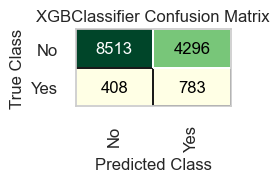

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.66      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.52     14000
weighted avg       0.89      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.6425     0.65642857 0.6675     0.66928571 0.67285714]
Accuracy score (average): 0.6617142857142857
F1 scores for 'Yes' values: [0.24224073 0.23162939 0.22738589 0.22184874 0.23666667]
Average F1 score: 0.517
ROC-AUC score: 0.661
PR-AUC score: 0.13
Log-loss: 0.713


Execution time: 40.78691220283508

RandomForestClassifier


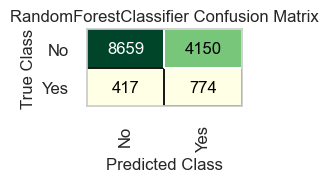

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.68      0.79     12809
         Yes       0.16      0.65      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.56      0.66      0.52     14000
weighted avg       0.89      0.67      0.75     14000

Cross-validation
Accuracy scores: [0.65785714 0.67642857 0.67107143 0.69392857 0.67964286]
Accuracy score (average): 0.6757857142857142
F1 scores for 'Yes' values: [0.2444795  0.22827939 0.21617021 0.24890447 0.23398804]
Average F1 score: 0.522
ROC-AUC score: 0.663
PR-AUC score: 0.132
Log-loss: 0.62


Execution time: 22.84815216064453

GradientBoostingClassifier


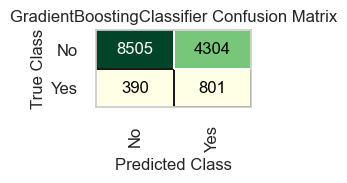

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.66      0.78     12809
         Yes       0.16      0.67      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.56      0.67      0.52     14000
weighted avg       0.89      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.65714286 0.67857143 0.69321429 0.67857143 0.67964286]
Accuracy score (average): 0.6774285714285715
F1 scores for 'Yes' values: [0.25465839 0.23728814 0.23779947 0.23339012 0.22605695]
Average F1 score: 0.519
ROC-AUC score: 0.668
PR-AUC score: 0.133
Log-loss: 0.612


Execution time: 25.304349899291992

LogisticRegression


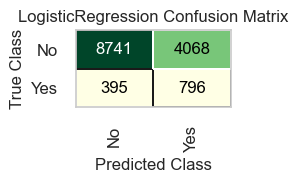

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     12809
         Yes       0.16      0.67      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.67857143 0.68142857 0.6825     0.7025     0.68392857]
Accuracy score (average): 0.6857857142857143
F1 scores for 'Yes' values: [0.25619835 0.24662162 0.24340426 0.24615385 0.23903697]
Average F1 score: 0.53
ROC-AUC score: 0.675
PR-AUC score: 0.138
Log-loss: 0.617


Execution time: 21.44376492500305

Parameters for the dataset and transformers: WOEEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_5, binary_features_5, categorical_features_5, other_features_5
XGBClassifier


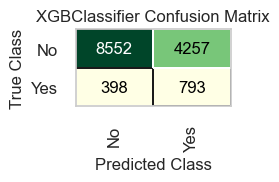

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.67      0.79     12809
         Yes       0.16      0.67      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.56      0.67      0.52     14000
weighted avg       0.89      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65178571 0.65428571 0.68392857 0.67357143 0.675     ]
Accuracy score (average): 0.6677142857142858
F1 scores for 'Yes' values: [0.24942263 0.21935484 0.24680851 0.22934233 0.23271501]
Average F1 score: 0.52
ROC-AUC score: 0.667
PR-AUC score: 0.133
Log-loss: 0.713


Execution time: 36.944725036621094

RandomForestClassifier


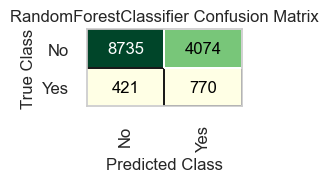

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.68      0.80     12809
         Yes       0.16      0.65      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.66      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.66071429 0.68964286 0.67357143 0.69428571 0.69107143]
Accuracy score (average): 0.6818571428571428
F1 scores for 'Yes' values: [0.24363057 0.24631396 0.23450586 0.24381625 0.2432196 ]
Average F1 score: 0.525
ROC-AUC score: 0.664
PR-AUC score: 0.133
Log-loss: 0.617


Execution time: 18.920604944229126

GradientBoostingClassifier


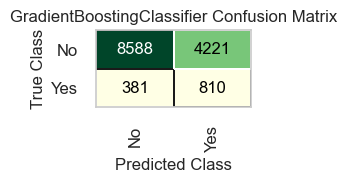

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.67      0.79     12809
         Yes       0.16      0.68      0.26      1191

    accuracy                           0.67     14000
   macro avg       0.56      0.68      0.52     14000
weighted avg       0.89      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.66821429 0.68678571 0.69964286 0.6825     0.68678571]
Accuracy score (average): 0.6847857142857142
F1 scores for 'Yes' values: [0.25857941 0.25740898 0.24438455 0.23690987 0.23805387]
Average F1 score: 0.525
ROC-AUC score: 0.675
PR-AUC score: 0.137
Log-loss: 0.611


Execution time: 21.79262900352478

LogisticRegression


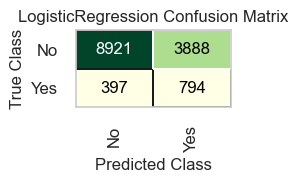

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.70      0.81     12809
         Yes       0.17      0.67      0.27      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.68      0.54     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.68107143 0.70214286 0.68178571 0.70535714 0.68071429]
Accuracy score (average): 0.6902142857142857
F1 scores for 'Yes' values: [0.26014913 0.26584507 0.24299065 0.25608656 0.23589744]
Average F1 score: 0.538
ROC-AUC score: 0.682
PR-AUC score: 0.141
Log-loss: 0.609


Execution time: 17.518097162246704



In [710]:
cross_vals, models, predictions, predictions_prob, scores4, preprocessors, optuna_df = get_empty_lists_and_dfs() 
run_models(scores4, X_train, y_train, X_val, y_val, 132,
           numeric_features_list3,
           binary_features_list3,
           categorical_features_list3,
           other_features_list3,
              scalers_list,
              num_imputers_list,
             cat_imputers_list,
              encoders_list,
             classifiers_tuned)

Parameters for the dataset and transformers: OneHotEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_1, binary_features_1, categorical_features_1, other_features_1
XGBClassifier


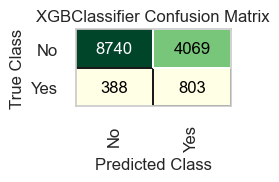

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     12809
         Yes       0.16      0.67      0.26      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.66821429 0.6925     0.69607143 0.68928571 0.68714286]
Accuracy score (average): 0.6866428571428572
F1 scores for 'Yes' values: [0.25976096 0.25583405 0.24623561 0.24740484 0.26262626]
Average F1 score: 0.531
ROC-AUC score: 0.678
PR-AUC score: 0.139
Log-loss: 0.69


Execution time: 86.07579493522644

Parameters for the dataset and transformers: WOEEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_1, binary_features_1, categorical_features_1, other_features_1
XGBClassifier


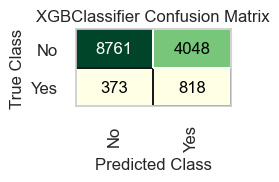

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     12809
         Yes       0.17      0.69      0.27      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.69      0.53     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.66714286 0.68142857 0.69035714 0.68892857 0.68892857]
Accuracy score (average): 0.6833571428571428
F1 scores for 'Yes' values: [0.2544     0.2440678  0.24674196 0.24457936 0.25619129]
Average F1 score: 0.534
ROC-AUC score: 0.685
PR-AUC score: 0.142
Log-loss: 0.689


Execution time: 81.58130836486816



In [284]:
cross_vals, models, predictions, predictions_prob, scores5, preprocessors, optuna_df = get_empty_lists_and_dfs() 
run_models(scores5, X_train, y_train, X_val, y_val, 315,
           numeric_features_list,
           binary_features_list,
           categorical_features_list,
           other_features_list,
              scalers_list,
              num_imputers_list,
             cat_imputers_list,
              encoders_list,
             classifiers_tuned_xgb)

In [711]:
scores4 = pd.DataFrame(scores4)
#scores4 = scores4.set_index("model_name")
scores4 = scores4.reset_index(drop=False)
scores4['model'] = scores4['model_name'].str.cat(scores4['index'].astype(str), sep=' ')

scores4 = scores4.set_index('model')
scores4 = pd.DataFrame(scores4).sort_values("ROC_AUC_score", ascending = False)

In [712]:
scores4

,index,precision_score,recall_score,model_name,a_score,f1_score,ROC_AUC_score,PR_AUC_score,loss,exec_time,encoders,cimputers,nimputers,scalers,num_features,cat_features,bin_features,other_features
model,,,,,,,,,,,,,,,,,,
LogisticRegression 7,7,0.563,0.682,LogisticRegression,0.694,0.538,0.682,0.141,0.609,17.518097,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
LogisticRegression 3,3,0.560,0.675,LogisticRegression,0.681,0.530,0.675,0.138,0.617,21.443765,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
GradientBoostingClassifier 6,6,0.559,0.675,GradientBoostingClassifier,0.671,0.525,0.675,0.137,0.611,21.792629,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
GradientBoostingClassifier 2,2,0.557,0.668,GradientBoostingClassifier,0.665,0.519,0.668,0.133,0.612,25.304350,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
XGBClassifier 4,4,0.556,0.667,XGBClassifier,0.668,0.520,0.667,0.133,0.713,36.944725,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
RandomForestClassifier 5,5,0.556,0.664,RandomForestClassifier,0.679,0.525,0.664,0.133,0.617,18.920605,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
RandomForestClassifier 1,1,0.556,0.663,RandomForestClassifier,0.674,0.522,0.663,0.132,0.620,22.848152,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5
XGBClassifier 0,0,0.554,0.661,XGBClassifier,0.664,0.517,0.661,0.130,0.713,40.786912,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_5,categorical_features_5,binary_features_5,other_features_5


In [713]:
scores5 = pd.DataFrame(scores5)
#scores5 = scores5.set_index("model_name")
scores5 = scores5.reset_index(drop=False)
scores5['model'] = scores5['model_name'].str.cat(scores5['index'].astype(str), sep=' ')

scores5 = scores5.set_index('model')
scores5 = pd.DataFrame(scores5).sort_values("ROC_AUC_score", ascending = False)

In [714]:
scores5

,index,precision_score,recall_score,model_name,a_score,f1_score,ROC_AUC_score,PR_AUC_score,loss,exec_time,encoders,cimputers,nimputers,scalers,num_features,cat_features,bin_features,other_features
model,,,,,,,,,,,,,,,,,,
XGBClassifier 1,1,0.564,0.685,XGBClassifier,0.684,0.534,0.685,0.142,0.689,81.581308,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1
XGBClassifier 0,0,0.561,0.678,XGBClassifier,0.682,0.531,0.678,0.139,0.690,86.075795,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_1,categorical_features_1,binary_features_1,other_features_1


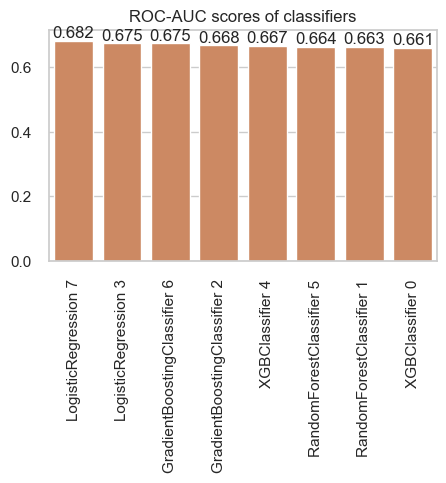

In [715]:
plot_bars(scores4, "ROC_AUC_score", "", "ROC-AUC scores of classifiers", (5,3))

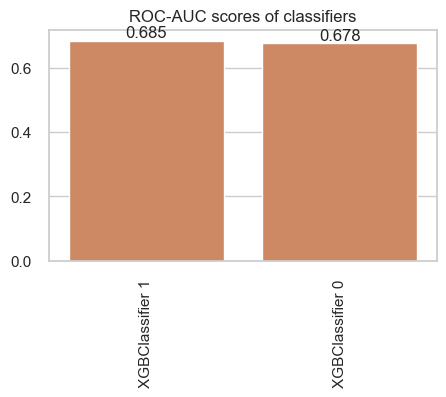

In [716]:
plot_bars(scores5, "ROC_AUC_score", "", "ROC-AUC scores of classifiers", (5,3))

It can be observed that the XGBoost classifier with the suggested parameters (n_estimators: 1000, max_depth: 9, learning_rate: 0.024246395212299744, subsample: 0.8) generates the best roc-auc scores comparing to other trained models, but the number of features does not affect scores (the roc-auc scores for the model trained with 315 and 132 features are the same). Also, it can be seen that the choice of the WOE encoder instead of One-hot encoder generates slighly better roc-auc scores.

#### Feature selection based on the results of exploratory analysis

Another approach was to select features based on the results of exploratory analysis. These features for which statistically significant differences in means (for numerical variables) and proportions (for binary and other categorical variables) were identified, were included in the list of selected features. Models with tuned parameters were trained on this combination of features. Results are presented bellow.

In [700]:
selected_features3= ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 
                     'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 
                     'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EDUCATION', 
                     'LIVING_CONDITIONS_1', 'LIVING_CONDITIONS_2', 'CB_enquiries_2', 'NAME_CONTRACT_TYPE', 
                     'FLAG_OWN_REALTY', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 
                     'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
                     'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE_Agriculture', 
                     'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Business Entity Type 3', 
                     'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Government', 
                     'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 12', 
                     'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 9', 
                     'ORGANIZATION_TYPE_Kindergarten', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Military',
                     'ORGANIZATION_TYPE_Police', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_School', 
                     'ORGANIZATION_TYPE_Security', 'ORGANIZATION_TYPE_Security Ministries', 
                     'ORGANIZATION_TYPE_Self-employed', 'ORGANIZATION_TYPE_Trade: type 3', 
                     'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7', 
                     'ORGANIZATION_TYPE_Transport: type 3', 'ORGANIZATION_TYPE_Transport: type 4', 
                     'ORGANIZATION_TYPE_University', 'GENDER_F', 'GENDER_M', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 
                     'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
                     'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

In [701]:
numeric_features_6 = [feature for feature in numeric_features_1 if feature in selected_features2]
binary_features_6 = [feature for feature in binary_features_1 if feature in selected_features2]
categorical_features_6 = [feature for feature in categorical_features_1 if feature in selected_features2]
other_features_6 = [feature for feature in other_features_1 if feature in selected_features2]

In [702]:
class num_features_6:
    def __init__(self, name, content):
        self.name = name
        self.content = content
        
class cat_features_6:
    def __init__(self, name, content):
        self.name = name
        self.content = content
        
class bin_features_6:
    def __init__(self, name, content):
        self.name = name
        self.content = content   

class o_features_6:
    def __init__(self, name, content):
        self.name = name
        self.content = content   
       

In [703]:
numeric_features_list4 = [
    #num_features_1("numeric_features_1", numeric_features_1)
   num_features_6("numeric_features_6", numeric_features_6)
]

categorical_features_list4 = [
  #  cat_features_1("categorical_features_1", categorical_features_1)
    cat_features_6("categorical_features_6", categorical_features_6)
]

binary_features_list4 = [
  #  bin_features_1("binary_features_1", binary_features_1)
    bin_features_6("binary_features_6", binary_features_6)
]

other_features_list4 = [
   # other_features_1("other_features_1", other_features_mod_1)
   o_features_6("other_features_6", other_features_6)
]

Parameters for the dataset and transformers: OneHotEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_6, binary_features_6, categorical_features_6, other_features_6
XGBClassifier


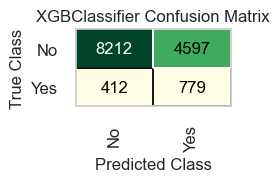

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.64      0.77     12809
         Yes       0.14      0.65      0.24      1191

    accuracy                           0.64     14000
   macro avg       0.55      0.65      0.50     14000
weighted avg       0.88      0.64      0.72     14000

Cross-validation
Accuracy scores: [0.62642857 0.64535714 0.66464286 0.67214286 0.66035714]
Accuracy score (average): 0.6537857142857143
F1 scores for 'Yes' values: [0.22056632 0.21252974 0.23844282 0.22466216 0.22620016]
Average F1 score: 0.502
ROC-AUC score: 0.648
PR-AUC score: 0.124
Log-loss: 0.755


Execution time: 33.960461139678955

RandomForestClassifier


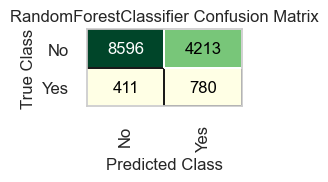

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.67      0.79     12809
         Yes       0.16      0.65      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.56      0.66      0.52     14000
weighted avg       0.89      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65428571 0.66642857 0.68964286 0.69642857 0.67321429]
Accuracy score (average): 0.6759999999999999
F1 scores for 'Yes' values: [0.23659306 0.22166667 0.23838738 0.24778761 0.2394015 ]
Average F1 score: 0.52
ROC-AUC score: 0.663
PR-AUC score: 0.132
Log-loss: 0.619


Execution time: 22.791489124298096

GradientBoostingClassifier


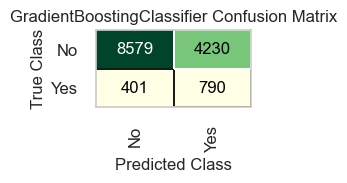

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.67      0.79     12809
         Yes       0.16      0.66      0.25      1191

    accuracy                           0.67     14000
   macro avg       0.56      0.67      0.52     14000
weighted avg       0.89      0.67      0.74     14000

Cross-validation
Accuracy scores: [0.65785714 0.66964286 0.68       0.68535714 0.67892857]
Accuracy score (average): 0.6743571428571429
F1 scores for 'Yes' values: [0.24208861 0.22334173 0.23418803 0.23590633 0.2322801 ]
Average F1 score: 0.521
ROC-AUC score: 0.667
PR-AUC score: 0.133
Log-loss: 0.611


Execution time: 23.507110118865967

LogisticRegression


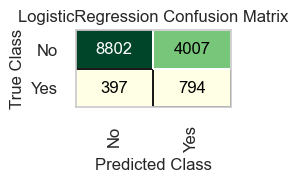

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.69      0.80     12809
         Yes       0.17      0.67      0.27      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.68      0.53     14000
weighted avg       0.89      0.69      0.75     14000

Cross-validation
Accuracy scores: [0.67       0.68357143 0.67964286 0.69035714 0.68392857]
Accuracy score (average): 0.6815
F1 scores for 'Yes' values: [0.24632953 0.23488774 0.23398804 0.24279476 0.23509075]
Average F1 score: 0.532
ROC-AUC score: 0.677
PR-AUC score: 0.139
Log-loss: 0.605


Execution time: 21.406705141067505

Parameters for the dataset and transformers: WOEEncoder, SimpleImputer(strategy='median'), SimpleImputer(fill_value=0, strategy='constant'), StandardScaler, numeric_features_6, binary_features_6, categorical_features_6, other_features_6
XGBClassifier


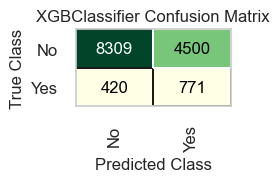

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.65      0.77     12809
         Yes       0.15      0.65      0.24      1191

    accuracy                           0.65     14000
   macro avg       0.55      0.65      0.51     14000
weighted avg       0.88      0.65      0.73     14000

Cross-validation
Accuracy scores: [0.66142857 0.65821429 0.675      0.65928571 0.66678571]
Accuracy score (average): 0.6641428571428571
F1 scores for 'Yes' values: [0.2428115  0.2313253  0.23657718 0.21416804 0.22314738]
Average F1 score: 0.505
ROC-AUC score: 0.648
PR-AUC score: 0.125
Log-loss: 0.73


Execution time: 30.536390781402588

RandomForestClassifier


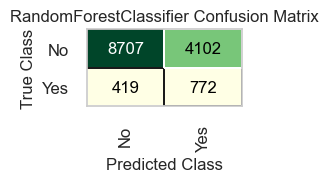

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.68      0.79     12809
         Yes       0.16      0.65      0.25      1191

    accuracy                           0.68     14000
   macro avg       0.56      0.66      0.52     14000
weighted avg       0.89      0.68      0.75     14000

Cross-validation
Accuracy scores: [0.65428571 0.67571429 0.69321429 0.7        0.6775    ]
Accuracy score (average): 0.6801428571428572
F1 scores for 'Yes' values: [0.24727838 0.23697479 0.22959641 0.23913043 0.2418136 ]
Average F1 score: 0.524
ROC-AUC score: 0.664
PR-AUC score: 0.133
Log-loss: 0.622


Execution time: 18.686326026916504

GradientBoostingClassifier


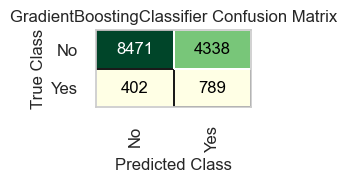

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.66      0.78     12809
         Yes       0.15      0.66      0.25      1191

    accuracy                           0.66     14000
   macro avg       0.55      0.66      0.52     14000
weighted avg       0.89      0.66      0.74     14000

Cross-validation
Accuracy scores: [0.66607143 0.68321429 0.68571429 0.69428571 0.67642857]
Accuracy score (average): 0.6811428571428572
F1 scores for 'Yes' values: [0.25020048 0.24123182 0.22942207 0.24514991 0.23608769]
Average F1 score: 0.516
ROC-AUC score: 0.662
PR-AUC score: 0.131
Log-loss: 0.617


Execution time: 19.799463272094727

LogisticRegression


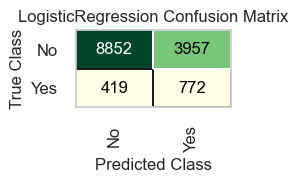

Classification Report:
              precision    recall  f1-score   support

          No       0.95      0.69      0.80     12809
         Yes       0.16      0.65      0.26      1191

    accuracy                           0.69     14000
   macro avg       0.56      0.67      0.53     14000
weighted avg       0.89      0.69      0.76     14000

Cross-validation
Accuracy scores: [0.67035714 0.6975     0.6825     0.7075     0.69821429]
Accuracy score (average): 0.6912142857142858
F1 scores for 'Yes' values: [0.25504439 0.24171889 0.23690987 0.26149684 0.2435094 ]
Average F1 score: 0.531
ROC-AUC score: 0.67
PR-AUC score: 0.136
Log-loss: 0.606


Execution time: 17.27903389930725



In [704]:
cross_vals, models, predictions, predictions_prob, scores6, preprocessors, optuna_df = get_empty_lists_and_dfs() 
run_models(scores6, X_train, y_train, X_val, y_val, 60,
           numeric_features_list4,
           binary_features_list4,
           categorical_features_list4,
           other_features_list4,
              scalers_list,
              num_imputers_list,
             cat_imputers_list,
              encoders_list,
             classifiers_tuned)

In [706]:
scores6 = pd.DataFrame(scores6)
#scores6 = scores6.set_index("model_name")
scores6 = scores6.reset_index(drop=False)
scores6['model'] = scores6['model_name'].str.cat(scores6['index'].astype(str), sep=' ')

scores6 = scores6.set_index('model')
scores6 = pd.DataFrame(scores6).sort_values("ROC_AUC_score", ascending = False)

In [707]:
scores6

,index,precision_score,recall_score,model_name,a_score,f1_score,ROC_AUC_score,PR_AUC_score,loss,exec_time,encoders,cimputers,nimputers,scalers,num_features,cat_features,bin_features,other_features
model,,,,,,,,,,,,,,,,,,
LogisticRegression 3,3,0.561,0.677,LogisticRegression,0.685,0.532,0.677,0.139,0.605,21.406705,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
LogisticRegression 7,7,0.559,0.670,LogisticRegression,0.687,0.531,0.670,0.136,0.606,17.279034,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
GradientBoostingClassifier 2,2,0.556,0.667,GradientBoostingClassifier,0.669,0.521,0.667,0.133,0.611,23.507110,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
RandomForestClassifier 5,5,0.556,0.664,RandomForestClassifier,0.677,0.524,0.664,0.133,0.622,18.686326,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
RandomForestClassifier 1,1,0.555,0.663,RandomForestClassifier,0.670,0.520,0.663,0.132,0.619,22.791489,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
GradientBoostingClassifier 6,6,0.554,0.662,GradientBoostingClassifier,0.661,0.516,0.662,0.131,0.617,19.799463,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
XGBClassifier 0,0,0.549,0.648,XGBClassifier,0.642,0.502,0.648,0.124,0.755,33.960461,OneHotEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6
XGBClassifier 4,4,0.549,0.648,XGBClassifier,0.649,0.505,0.648,0.125,0.730,30.536391,WOEEncoder,SimpleImputer,SimpleImputer,StandardScaler,numeric_features_6,categorical_features_6,binary_features_6,other_features_6


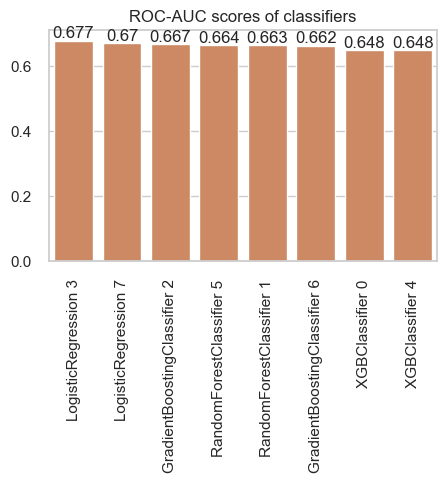

In [717]:
plot_bars(scores6, "ROC_AUC_score", "", "ROC-AUC scores of classifiers", (5,3))

It can be observed that this approach did not generate better roc-auc scores than other feature selection approaches. the logistic regression classifier preprocessed with one-hot encoder gave the best scores compared to other models.

#### Comparing different machine learning models

Scores of the models trained with different parameters, feature combinations and transformers were compared between each other (scores presented in the data table and the plot).

In [729]:
roc_auc_scores_full = pd.concat([scores1.loc[:,'ROC_AUC_score'],
                                 scores2.loc[:,'ROC_AUC_score'],
                          scores4.loc[:,'ROC_AUC_score'],scores5.loc[:,'ROC_AUC_score'],
                               scores6.loc[:,'ROC_AUC_score'] ], axis=1)

roc_auc_scores_full.columns =['roc_auc_score1','roc_auc_score2',
                       'roc_auc_score4', 'roc_auc_score5', 'roc_auc_score6']

In [730]:
roc_auc_scores_full

,roc_auc_score1,roc_auc_score2,roc_auc_score4,roc_auc_score5,roc_auc_score6
model,,,,,
GradientBoostingClassifier 11,0.680,0.676,NaN,NaN,NaN
GradientBoostingClassifier 3,0.679,0.673,NaN,NaN,NaN
LogisticRegression 12,0.675,0.672,NaN,NaN,NaN
RandomForestClassifier 1,0.674,0.672,0.663,NaN,0.663
RandomForestClassifier 9,0.670,0.668,NaN,NaN,NaN
LogisticRegression 4,0.669,0.672,NaN,NaN,NaN
XGBClassifier 0,0.662,0.655,0.661,0.678,0.648
XGBClassifier 8,0.660,0.656,NaN,NaN,NaN
AdaBoostClassifier 7,0.659,0.658,NaN,NaN,NaN


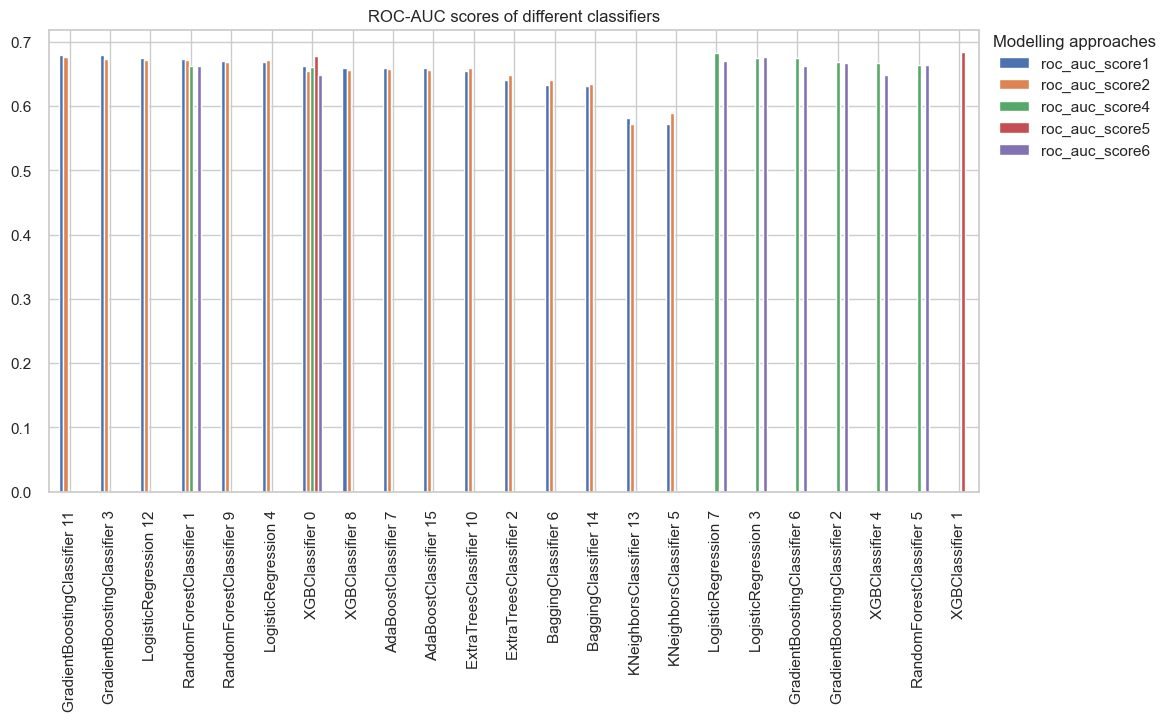

In [731]:
sns.set(style='whitegrid')
roc_auc_scores_full.plot(kind='bar', figsize=(12, 6))
plt.title('ROC-AUC scores of different classifiers')
plt.xticks(rotation=90)
plt.legend(title='Modelling approaches', bbox_to_anchor=(1, 1.02),
                     loc='upper left')  
plt.xlabel('')
plt.ylabel('')
plt.show()

#### Predicting clients with payment difficulties on the best performing models and the data from the test dataset

The best performing models (the Logistic regression classifier with data preprocessed with the WOEencoder and etc. and the combination of 132 features; the Gradient Boosting classifier trained with the WOE encoder and etc. and all features; and the XGBoost classifier with tuned parameters, the WOE encoder and all features) were selected for predicting clients with payment difficulties on the test dataset (separated from the random sample for machine learning).

In [722]:
model_lr = joblib.load('model_LogisticRegression_WOEEncoder_SimpleImputer(strategy=median)_SimpleImputer(fill_value=0, strategy=constant)_numeric_features_5.joblib')
model_gb = joblib.load('model_GradientBoostingClassifier_WOEEncoder_SimpleImputer(strategy=median)_SimpleImputer(fill_value=0, strategy=constant)_numeric_features_1.joblib')
model_hg = joblib.load('model_XGBClassifier_WOEEncoder_SimpleImputer(strategy=median)_SimpleImputer(fill_value=0, strategy=constant)_numeric_features_1.joblib')

In [723]:
model_list = [model_lr, model_gb, model_hg]


In [724]:
def plot_confusion_matrix(conf_matrix, classes, figsize):
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGn",
                xticklabels=classes_target, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [725]:
def test_model(estimator, x_test, y_test, classes):
    prediction = estimator.predict(x_test)
    prediction_prob = estimator.predict_proba(x_test)

    #Metrics:
    f1 = f1_score(y_test, prediction, average='macro').round(3)
    prec = precision_score(y_test, prediction, average='macro').round(3)
    rec = recall_score(y_test, prediction, average='macro').round(3)
    acc_sq = accuracy_score(y_test, prediction).round(3)
    report = classification_report(y_test, prediction, target_names=classes)
    loss = log_loss(y_test, prediction_prob).round(3)
    roc_auc = roc_auc_score(y_test, prediction).round(3)
    pr_auc = average_precision_score(y_test, prediction).round(3)
    conf_matrix = cfm(y_test, prediction)
    
   #Prints:
    print (estimator[3].__class__.__name__)
    plot_confusion_matrix(conf_matrix, classes, (3,2))
    print("Classification Report:")
    print(report)
 
    print (f"Accuracy score: {acc_sq}")
    print (f"F1 score: {f1}")
    print (f"ROC-AUC score: {roc_auc}")
    print (f"PR-AUC score: {pr_auc}")
    print (f"Log-loss: {loss}")

LogisticRegression


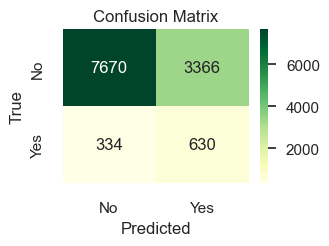

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.69      0.81     11036
         Yes       0.16      0.65      0.25       964

    accuracy                           0.69     12000
   macro avg       0.56      0.67      0.53     12000
weighted avg       0.89      0.69      0.76     12000

Accuracy score: 0.692
F1 score: 0.53
ROC-AUC score: 0.674
PR-AUC score: 0.131
Log-loss: 0.612
GradientBoostingClassifier


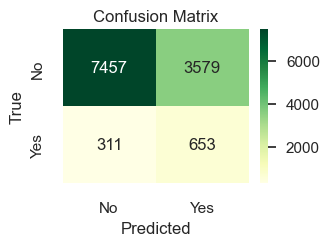

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.79     11036
         Yes       0.15      0.68      0.25       964

    accuracy                           0.68     12000
   macro avg       0.56      0.68      0.52     12000
weighted avg       0.90      0.68      0.75     12000

Accuracy score: 0.676
F1 score: 0.522
ROC-AUC score: 0.677
PR-AUC score: 0.13
Log-loss: 0.607
XGBClassifier


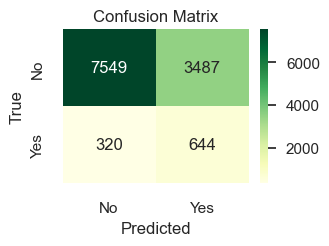

Classification Report:
              precision    recall  f1-score   support

          No       0.96      0.68      0.80     11036
         Yes       0.16      0.67      0.25       964

    accuracy                           0.68     12000
   macro avg       0.56      0.68      0.53     12000
weighted avg       0.89      0.68      0.75     12000

Accuracy score: 0.683
F1 score: 0.526
ROC-AUC score: 0.676
PR-AUC score: 0.131
Log-loss: 0.702


In [726]:
for model in model_list:
    test_model(model, X_test, y_test, classes_target)

The roc-auc scores (and other scores) are quite similar as the scores generated on the validation dataset. The XGBoost classifier generated the best scores, thus, it was chosen for the use in the API and deployment.

In [727]:
joblib.dump(model_hg, 'XGBoost.joblib')

['XGBoost.joblib']

#### BUILDING AND RUNNING DEEP LEARNING MODELS

Also, it was decided to train a deep learning model to predict clients with loan payment difficulties. For that purpose, the tensorflow library adn keras modules were used. The model was trainen on the full dataset of 3057511 cases and 315 features.

##### Spliting the data into training and test datasets

The target variable was separated, data were split into training (70 percent) and test  (30 percent) datasets.

In [541]:
X = fulldata_train.drop(['TARGET'],axis=1)
y = fulldata_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

##### Preprocessing the data

Data were preprocessed with transformers in in the lists which were used for sklearn machine learning (WOE encoder was chosen). Also, random undersampling was applied for the data as it was highly unbalanced.

In [542]:
num_transformer, bin_transformer, cat_transformer, imp_transformer = get_transformers(scalers_list[0], 
                                                                                        num_imputers_list[0],
                                                                                        cat_imputers_list[0],
                                                                                        encoders_list[1])
             

In [543]:
preprocessor = ColumnTransformer(
                       transformers=[
                        ('numeric', num_transformer, numeric_features_list[0].content),
                        ('binary', bin_transformer, binary_features_list[0].content),
                        ('categorical', cat_transformer, categorical_features_list[0].content),
                        ('other', imp_transformer, other_features_list[0].content)
                    ])

In [544]:
X_pipe_train = pd.DataFrame(preprocessor.fit_transform(X_train, y_train))
X_pipe_test = pd.DataFrame(preprocessor.fit_transform(X_test,y_test))
randomundersampler = RandomUnderSampler(random_state=42)
X_resampled_train, y_resampled_train = randomundersampler.fit_resample(X_pipe_train, y_train)


##### Running the model

In [557]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_resampled_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[AUC(name='roc_auc')],
              loss_weights = [0.08, 0.92]
             )

In [558]:
start_time3 = time.time()
model.fit(X_resampled_train, y_resampled_train, epochs=20, batch_size=32, validation_split=0.2)
end_time3 = time.time()
exec_time3 = end_time3 - start_time3
print('')
print (f'Execution time: {exec_time3}')

Epoch 1/20
  1/865 [..............................] - ETA: 5:50 - loss: 0.0951 - roc_auc: 0.4479

2023-08-30 10:33:11.970129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


865/865 [==============================] - ETA: 0s - loss: 0.0490 - roc_auc: 0.6877

2023-08-30 10:33:17.595886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


865/865 [==============================] - 7s 8ms/step - loss: 0.0490 - roc_auc: 0.6877 - val_loss: 0.0634 - val_roc_auc: 0.0000e+00
Epoch 2/20
865/865 [==============================] - 6s 7ms/step - loss: 0.0460 - roc_auc: 0.7395 - val_loss: 0.0685 - val_roc_auc: 0.0000e+00
Epoch 3/20
865/865 [==============================] - 6s 7ms/step - loss: 0.0451 - roc_auc: 0.7532 - val_loss: 0.0613 - val_roc_auc: 0.0000e+00
Epoch 4/20
865/865 [==============================] - 6s 7ms/step - loss: 0.0447 - roc_auc: 0.7589 - val_loss: 0.0649 - val_roc_auc: 0.0000e+00
Epoch 5/20
865/865 [==============================] - 6s 7ms/step - loss: 0.0445 - roc_auc: 0.7618 - val_loss: 0.0578 - val_roc_auc: 0.0000e+00
Epoch 6/20
865/865 [==============================] - 6s 7ms/step - loss: 0.0442 - roc_auc: 0.7651 - val_loss: 0.0685 - val_roc_auc: 0.0000e+00
Epoch 7/20
865/865 [==============================] - 7s 8ms/step - loss: 0.0441 - roc_auc: 0.7670 - val_loss: 0.0658 - val_roc_auc: 0.0000e+00
Epo

##### Predicting on the test data and evaluating the model

In [559]:
predictions_test = model.predict(X_pipe_test)

 128/2883 [>.............................] - ETA: 3s

2023-08-30 10:35:25.349925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2883/2883 [==============================] - 4s 1ms/step


In [560]:
loss, roc_auc = model.evaluate(X_pipe_test, y_test)
print(f"Test loss: {loss:.4f}, Test ROC-AUC: {roc_auc:.4f}")

2883/2883 [==============================] - 14s 5ms/step - loss: 0.0390 - roc_auc: 0.7511
Test loss: 0.0390, Test ROC-AUC: 0.7511


The confusion matrix and classification report for this model predictions are presented bellow.

In [561]:
classes_target=['No', 'Yes']
size_target = (200, 100)

In [562]:
threshold = 0.5
y_pred = [1 if prob >= threshold else 0 for prob in predictions_test]

In [563]:
conf_matrix = cfm(y_test, y_pred)

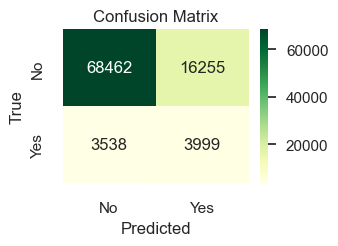

In [564]:
plot_confusion_matrix(conf_matrix, classes_target, (3,2))

In [565]:
report = classification_report(y_test, y_pred, target_names=classes_target)

print(report)

              precision    recall  f1-score   support

          No       0.95      0.81      0.87     84717
         Yes       0.20      0.53      0.29      7537

    accuracy                           0.79     92254
   macro avg       0.57      0.67      0.58     92254
weighted avg       0.89      0.79      0.83     92254



In [566]:
report_dict = classification_report(y_test, y_pred, target_names=classes_target, output_dict=True)

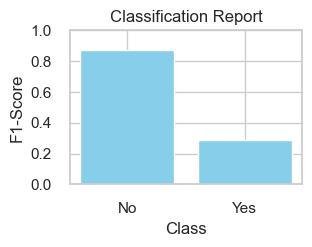

In [567]:
plt.figure(figsize=(3, 2))
plt.bar(classes_target, [report_dict[label]['f1-score'] for label in classes_target], color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Classification Report')
plt.ylim(0, 1)
plt.show()

It can be seen that the deep learning model (the roc-auc score - 0.751; f1 score for 'Yes' - 0.29; f1 score for "No" - 0.87) generates better scores than any one of machine learning models trained with the algorithms in the sklearn library. 

The model is saved to be used for the API and deployment. 

In [568]:
from keras.models import load_model

model.save('tensorflow_model.h5')


#### Using the selected model for prediction

The XG Boost model as well as the deep learning model will be used for predicting probabilities of clients' having difficulties to pay loans. The dataset which will be used for prediction is the fulldata_test which was preprocessed from the 'application_test.csv' file (see the exploratory analysis part). The code bellow is used to randomy select client ids (the number of ids could be chosen arbitrarily) from this dataset an generate probabilites for a client to have loan payment difficulties by the pretained models. 

In order to provide predictions from the deep learning model, the data has to be preprocessed. The preporcessor is taken from the XG Boost model pipeline. However, the function 'fit_transform' requires the target variable as an argument which is not present in the fulldata_test dataset (but not uses it for generating predictions). In order to solve this issue, a random pandas Series with binary values 0 and 1 were generated and included as an argument for the fit_transform function.

In [23]:
model_xg = joblib.load('XGBoost.joblib')
model_tf = tf.keras.models.load_model('tensorflow_model.h5')

Metal device set to: Apple M2


2023-08-30 19:15:49.748475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-30 19:15:49.748887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
fulldata_test_prediction = fulldata_test.copy()
fulldata_test_prediction = fulldata_test.set_index('SK_ID_CURR')

random_binary_values = [random.randint(0, 1) for _ in range(len(fulldata_test_prediction))]
random_df = pd.DataFrame({'random_y': random_binary_values})
#random_df = random_df.set_index(fulldata_test_prediction.index)
random_sr = random_df.iloc[:,0]

In [19]:
#fulldata_test_prediction = fulldata_test.set_index('SK_ID_CURR')
fulldata_test_prediction = fulldata_test_prediction.reset_index(drop=False)

X_prediction = pd.DataFrame(model_xg[:2].fit_transform(fulldata_test_prediction, random_sr))
X_prediction = X_prediction.set_index(fulldata_test_prediction.set_index("SK_ID_CURR").index)

##### Prediction of random cases from the dataset:

In [24]:
random_cases = X_prediction.sample(n=5)


In [25]:
prob1_list = np.round(model_xg[3].predict_proba(random_cases), 3)
prob2_list = np.round(model_tf.predict(random_cases), 3)

2023-08-30 19:15:59.870294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step


In [26]:
for i in range(len(random_cases)):
    print(f' Probability that the client whose id is {random_cases.index[i]} \
will experience paying difficulties \n(prediction by a XGBoost classifier):  {prob1_list[i][1]:.{3}f}')
    print('')
    print(f' Probability that the client whose id is {random_cases.index[i]} \
will experience paying difficulties \n(prediction by a deep learning model):  {prob2_list[i][0]:.{3}f}')
    print('')
    print('')
    print('')

 Probability that the client whose id is 119251 will experience paying difficulties 
(prediction by a XGBoost classifier):  0.682

 Probability that the client whose id is 119251 will experience paying difficulties 
(prediction by a deep learning model):  0.408



 Probability that the client whose id is 318264 will experience paying difficulties 
(prediction by a XGBoost classifier):  0.787

 Probability that the client whose id is 318264 will experience paying difficulties 
(prediction by a deep learning model):  0.190



 Probability that the client whose id is 414050 will experience paying difficulties 
(prediction by a XGBoost classifier):  0.807

 Probability that the client whose id is 414050 will experience paying difficulties 
(prediction by a deep learning model):  0.697



 Probability that the client whose id is 184060 will experience paying difficulties 
(prediction by a XGBoost classifier):  0.942

 Probability that the client whose id is 184060 will experience paying dif

##### Prediction of cases by a client id input:

Also, the ids could be provided by the user input and probabilities generated on them.

In [31]:
id = int(input("What is the id of a client whose riskiness \
to experience paying difficulties you would like to predict?  "))


What is the id of a client whose riskiness to experience paying difficulties you would like to predict?  184060


In [32]:
case = pd.DataFrame(X_prediction.loc[id,:]).transpose()

In [33]:
prob_input1 = model_xg[3].predict_proba(case)
prob_input2 = model_tf.predict(case)

1/1 [==============================] - 0s 14ms/step


In [35]:
print(f' Probability that the client whose id is {int(case.index[0])} \
will experience paying difficulties \n(prediction by a HGBoost classifier): {prob_input1[0][1]:.{3}f}')
print('')
print(f' Probability that the client whose id is {int(case.index[0])} \
will experience paying difficulties \n(prediction by a deep learning model): {prob_input2[0][0]:.{3}f}')


 Probability that the client whose id is 184060 will experience paying difficulties 
(prediction by a HGBoost classifier): 0.942

 Probability that the client whose id is 184060 will experience paying difficulties 
(prediction by a deep learning model): 0.603


## Conclusions

These final conclusion can be made;

1. From the exploratory analysis it can be observed that it is more likely that the clients will experience loan payment difficulties if they (some hypotheses were confirmed others not):

- are of older age;
- have been living longer in the same area;
- have not changed their id document for a longer time;
- live in a region with a rating of higher number (rather the region 3 than the region 1);
- live in a region with a rating of higher number (rather the region 3 than the region 1) taking city into account;
- the living conditions of the factor 2 of the clients have higher scores (e.g. have older houses);
- take cash loans;
- own real estate;
- are on maternity leave or unemployed;
- provided home and work phone numbers;
- their permanent adress does not match contact or work adresses in region or city levels;
- work in agriculture, business entity (type 3), industry (type 1,11, 13, 3, 4, 8), construction, cleaning, mobile, postal, realtor, restaurant, security, trade (type 1, 3, 7), transport (type 3, 4);
- are self_employed;
- are in civil mariage or single/ not married;
- were unaccompanied or accompanied by a group of people when applying for a loan;
- live in rented apartment or with parents; 
- work as low-skill laborers, laborers, drivers, security staff, waiters/ barmen staff, cooking staff (percentages higher than 10 percent in the "No" group);
- live in specific housing, walls are wooden (percentages higher than 9 percent in the "Yes" group);
- are men.

2. It is more likely that the clients will not experience loan payment difficulties if they:
- have higher income;
- they took credits of higher amount;
- live in more populated regions;
- have better education;
- the living conditions of the factor 2 of the clients have higher scores (e.g have houses of with longer periods ofexploitation);
- numbers of the Credit Bureau enquiries about the person of teh factor 2 are higher (i.e., more enquiries during the last quartier).
- take revolving loans;
- own real estate;
- provided their mobile phone number;
- work for a bank, the government, industry (type 12, 9), kindergarden, medicine, military, police, school, security ministries, trade (type 6), university;
- are married or widows;
- work as core staff, accountants, medicine staff, managers, private service staff, high skill tech staff, hr staff (percentages less than 7 percent in the "Yes" group;
- live in monolithic housing (percentages lower than 5 in the "Yes" group);
- are women.

3.  the XGBoost classifier:
 - with these parameters (n_estimators: 1000, max_depth: 9, learning_rate: 0.024246395212299744, subsample: 0.8) suggested by the Bayesian optimization, 
 - trained on all 315 features selected after initial exploratory analysis (which included reduction dimension, cleaning data, transformation of data joined from tables with time dimension, recoding of some features, etc.) 
 - train with such transformers as WOE encoder, standardscaler is able to generate the highest roc-auc WOEEncoder, SimpleImputer(strategy=median) for numerical features, SimpleImputer(fill_value=0, strategy=constant) for categorical features, standard scaler for numeric features
 
 is able to generathe the highest roc-auc scores (0.68 for validation data and 0.676 for test data).
 
 4. A deep learning model trained with the tensorflow model generates event higher roc-auc scores comparing to XGboos classifier - 0.75. 
 
 5. The API is created which randomly selects client ids from the test dataset and, based on two models' - XG Boost classifier and the dee learning model - predictions, provides probabilities that the clients will experience difficulties while paying loans. Also, predictions could be generated by by the user input of client ids. Such API could be valuable to the Home Credit Club company which, taking into account these prediction, could make decisions either to accept applications for credits or not.
 
#### Limitations and suggestions for improvement:

1. Scores of classifiers which were tested are mediocre (though they are better than random guessing). Maybe scores could be improved by more advanced feature engeneering (creation of new features) and hyperparameter tuning, arso by trying different datatransformers.


## References

1. Dhruv Narayanan. Home Credit Default Risk (Part 1) : Business Understanding, Data Cleaning and EDA, Medium, https://medium.com/analytics-vidhya/home-credit-default-risk-part-1-business-understanding-data-cleaning-and-eda-1203913e979c
3. Dhruv Narayanan.Home Credit Default Risk (Part 2): Feature Engineering and Modelling-I, Medium, https://medium.com/@dhruvnarayanan20/home-credit-default-risk-part-2-feature-engineering-and-modelling-i-be9385ad77fd
3. Home Credit Default Risk, https://www.kaggle.com/competitions/home-credit-default-risk/data